In [213]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from prettytable import PrettyTable
import requests
import folium
import missingno as msno
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder,StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.base import BaseEstimator, TransformerMixin
from prettytable import PrettyTable

%matplotlib inline

In [2]:
df = pd.read_csv('loan_data.csv', low_memory=False)

In [3]:
X, y = df.loc[:, [column for column in df.columns if column != "loan_status"]], df.loan_status
X_1, X_test, y_1, y_test = train_test_split(X, y, test_size=0.1, random_state=6, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_1, y_1, test_size=0.1, random_state=6, stratify=y_1)

In [4]:
EDA = pd.concat((X_train, y_train), axis=1)

In [5]:
#EDA 그룹
target = 'loan_status'
#명목형
##1
info =['emp_length', 'addr_state',
      'term', 'verification_status', 'grade','sub_grade', 'purpose'] 


#연속형
credit = ['fico_range_high','fico_range_low', 'dti', 'inq_last_6mths']
bal = ['annual_inc','loan_amnt', 'revol_util', 'il_util']
acct = ['open_rv_24m','open_il_24m','acc_open_past_24mths',
         'open_rv_12m','open_il_12m','num_tl_op_past_12m',
         'open_act_il','num_actv_rev_tl']


feature = info+credit+bal+acct

In [210]:
EDA[['tot_coll_amt','loan_status']].groupby('loan_status').mean()

,tot_coll_amt
loan_status,
Charged Off,238.994984
Fully Paid,233.996767


- open_il_24m / open_il_12m / open_act_il의 관계
- open_rv_24m / open_rv_12m / num_actv_rev_tl의 관계

In [7]:
EDA[info+credit+bal+acct].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1089701 entries, 1126992 to 162341
Data columns (total 23 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   emp_length            1026221 non-null  object 
 1   addr_state            1089701 non-null  object 
 2   term                  1089701 non-null  object 
 3   verification_status   1089701 non-null  object 
 4   grade                 1089701 non-null  object 
 5   sub_grade             1089701 non-null  object 
 6   purpose               1089701 non-null  object 
 7   fico_range_high       1089701 non-null  float64
 8   fico_range_low        1089701 non-null  float64
 9   dti                   1089385 non-null  float64
 10  inq_last_6mths        1089701 non-null  float64
 11  annual_inc            1089701 non-null  float64
 12  loan_amnt             1089701 non-null  float64
 13  revol_util            1089003 non-null  float64
 14  il_util               376793 non-n

In [211]:
from prettytable import PrettyTable

na_table = PrettyTable()
na_table.field_names = ["변수명", "결측치 개수", "전체 비율"]

for col in info+credit+bal+acct:
    na_cnt = EDA[col].isna().sum()
    total_rows = EDA.shape[0]
    ratio = (na_cnt / total_rows) * 100
    if na_cnt != 0:
        na_table.add_row([col, na_cnt, f'{ratio:.2f}%'])

NameError: name 'info' is not defined

In [9]:
na_table

변수명,결측치 개수,전체 비율
emp_length,63480,5.83%
dti,316,0.03%
revol_util,698,0.06%
il_util,712908,65.42%
open_rv_24m,654028,60.02%
open_il_24m,654028,60.02%
acc_open_past_24mths,38350,3.52%
open_rv_12m,654028,60.02%
open_il_12m,654028,60.02%
num_tl_op_past_12m,54676,5.02%


In [246]:
count_outliers(EDA_pipe1, 'revol_util')

52

In [218]:
def make_na_table(group, df=EDA):
    na_table = PrettyTable()
    na_table.field_names = ["변수명", "결측치 개수", "전체 비율"]

    for col in group:
        na_cnt = df[col].isna().sum()
        total_rows = df.shape[0]
        ratio = (na_cnt / total_rows) * 100
        na_table.add_row([col, na_cnt, f'{ratio:.2f}%'])
    print(na_table)

In [219]:
accts = ['open_acc_6m','acc_open_past_24mths','open_rv_24m','open_il_24m','num_tl_op_past_12m','open_rv_12m','open_il_12m',
         'total_acc','total_cu_tl','num_rev_accts','num_il_tl','mort_acc','mo_sin_rcnt_tl','num_sats', 'total_bal_ex_mort', 'tot_hi_cred_lim', 
         'num_sats','pct_tl_nvr_dlq','tot_cur_bal','all_util', 'avg_cur_bal', 'num_tl_120dpd_2m','num_tl_30dpd', 'num_tl_90g_dpd_24m', 
         'open_acc','open_act_il','num_op_rev_tl','num_rev_tl_bal_gt_0',
         'acc_now_delinq','num_tl_30dpd','num_tl_120dpd_2m','num_accts_ever_120_pd']

In [220]:
make_na_table(accts)

+-----------------------+-------------+-----------+
|         변수명        | 결측치 개수 | 전체 비율 |
+-----------------------+-------------+-----------+
|      open_acc_6m      |    654028   |   60.02%  |
|  acc_open_past_24mths |    38350    |   3.52%   |
|      open_rv_24m      |    654028   |   60.02%  |
|      open_il_24m      |    654028   |   60.02%  |
|   num_tl_op_past_12m  |    54676    |   5.02%   |
|      open_rv_12m      |    654028   |   60.02%  |
|      open_il_12m      |    654028   |   60.02%  |
|       total_acc       |      0      |   0.00%   |
|      total_cu_tl      |    654028   |   60.02%  |
|     num_rev_accts     |    54677    |   5.02%   |
|       num_il_tl       |    54676    |   5.02%   |
|        mort_acc       |    38350    |   3.52%   |
|     mo_sin_rcnt_tl    |    54676    |   5.02%   |
|        num_sats       |    45270    |   4.15%   |
|   total_bal_ex_mort   |    38350    |   3.52%   |
|    tot_hi_cred_lim    |    54676    |   5.02%   |
|        num_sats       

## 1. util(한도대비 사용률) 결측 처리 - 잔액과 한도 변수 사용

In [31]:
util = ['revol_util', 'il_util']
make_na_table(util)

+------------+-------------+-----------+
|   변수명   | 결측치 개수 | 전체 비율 |
+------------+-------------+-----------+
| revol_util |     698     |   0.06%   |
|  il_util   |    712908   |   65.42%  |
+------------+-------------+-----------+


### 1-1. il_util 결측 대체 


In [57]:
il = ["il_util", "total_bal_il", "total_il_high_credit_limit", "loan_status"]

In [33]:
make_na_table(il)

+----------------------------+-------------+-----------+
|           변수명           | 결측치 개수 | 전체 비율 |
+----------------------------+-------------+-----------+
|          il_util           |    712908   |   65.42%  |
|        total_bal_il        |    654028   |   60.02%  |
| total_il_high_credit_limit |    54676    |   5.02%   |
|        loan_status         |      0      |   0.00%   |
+----------------------------+-------------+-----------+


In [34]:
EDA[il].isna().sum() / EDA[il].shape[0] * 100

il_util                       65.422350
total_bal_il                  60.019033
total_il_high_credit_limit     5.017523
loan_status                    0.000000
dtype: float64

$$ total\_bal\_il = total\_bal\_ex\_mort - revol\_bal $$
1. total_bal_il을 구해보기 위해서 total_bal_ex_mort와 revol_bal사용, 위 수식이 유효한지 증명

In [35]:
il_bal = ["total_bal_il", "total_bal_ex_mort", "revol_bal"]
EDA[il_bal].isna().sum()

total_bal_il         654028
total_bal_ex_mort     38350
revol_bal                 0
dtype: int64

In [36]:
EDA[il_bal].head()

,total_bal_il,total_bal_ex_mort,revol_bal
1126992,NaN,18861.0,18861.0
530674,7436.0,26159.0,18723.0
465057,126565.0,131188.0,4623.0
148918,NaN,76482.0,11011.0
31145,NaN,46069.0,37090.0


**검증할 식 (reval_bal에는 na값이 없음)**
1. total_bal_ex_mort = total_bal_il + revol_bal (한쪽이라도 결측일 경우 연산 제외됨)
2. total_bal_ex_mort = revol_bal (total_bal_il이 결측일 때)

In [37]:
#total_bal_il이 결측이 아닌 것중 93% 이상의 행이 위 수식에 따르고 있다.

len_bal = len(EDA[il_bal])
ex_na = len(EDA[il_bal][(EDA['total_bal_il'].isna())])
equal = len(EDA[il_bal][EDA['total_bal_ex_mort'] == (EDA['total_bal_il']+EDA['revol_bal'])])
eq_rev = len(EDA[il_bal][(EDA['total_bal_ex_mort'] == EDA['revol_bal'])&(EDA['total_bal_il'].isna())])
outlier = (len_bal-ex_na+eq_rev)-(equal+eq_rev)

print(f'총 길이: {len_bal}')
print(f'결측값: {ex_na}')
print(f'논리에 맞는 수: {equal+eq_rev}')
print(f'값이 있는 것 중에 논리의 맞지 않는 경우: {outlier}')
print("값이 있는 것 중 논리 맞지 않는 비율:", round(outlier / (len_bal-ex_na+eq_rev) * 100, 2),'%')

총 길이: 1089701
결측값: 654028
논리에 맞는 수: 478571
값이 있는 것 중에 논리의 맞지 않는 경우: 32872
값이 있는 것 중 논리 맞지 않는 비율: 6.43 %


In [38]:
#논리적 이상치, 스냅샷으로 예상. 연산시 -으로 나오게 됨 -> il값은 0으로 대체
EDA[il_bal].loc[(EDA['revol_bal'] > EDA['total_bal_ex_mort']) & EDA['total_bal_il'].isna()]

,total_bal_il,total_bal_ex_mort,revol_bal
830590,NaN,18448.0,25823.0
1006450,NaN,41748.0,72834.0
44253,NaN,16565.0,21267.0
828940,NaN,32480.0,121162.0
265246,NaN,35930.0,92621.0
...,...,...,...
99025,NaN,15377.0,21012.0
776706,NaN,17676.0,37815.0
37848,NaN,6082.0,55783.0
124077,NaN,45156.0,100263.0


In [39]:
EDA.total_bal_il.fillna(EDA.total_bal_ex_mort - EDA.revol_bal, inplace=True)
EDA.total_bal_il = EDA.total_bal_il.apply(lambda x: 0 if x < 0 else x)

2. total_bal_il == 0 or total_il_high_credit_limit == 0 or num_il_tl == 0인 행의 il_util 모두 0으로 변경

In [40]:
EDA.loc[(EDA['total_bal_il'] == 0) | (EDA['total_il_high_credit_limit'] == 0), 'il_util'] = 0
EDA[il].isna().sum() / EDA.shape[0] * 100

il_util                       53.691058
total_bal_il                   3.519314
total_il_high_credit_limit     5.017523
loan_status                    0.000000
dtype: float64

$$ il\_util (\%) = \frac{total\_bal\_il}{total\_il\_high\_credit\_limit} * 100 $$

  
3. il_util 결측 행에 대해서 total_bal_il != np.nan and total_il_high_credit_limit != np.nan 인경우,   
위 수식에 대해서 il_util을 계산해볼 수 있다.

단, 모든 il_util이 위 수식에 의한 값인지 먼저 확인후 진행

**total_il_high_credit_limit이 결측인 경우**

In [64]:
#1. 둘 다 0인 값인 경우
EDA_pipe[il][(EDA_pipe['total_il_high_credit_limit'].isna())&(EDA_pipe['total_bal_il']==0)]

,il_util,total_bal_il,total_il_high_credit_limit,loan_status


In [42]:
# 2. 전부 결측인경우 / il_util 결측인 경우 
EDA[il][(EDA['total_il_high_credit_limit'].isna())&(EDA['total_bal_il'].isna()) ]

,il_util,total_bal_il,total_il_high_credit_limit,loan_status
933637,NaN,NaN,NaN,Fully Paid
919918,NaN,NaN,NaN,Fully Paid
1192171,NaN,NaN,NaN,Fully Paid
953956,NaN,NaN,NaN,Fully Paid
921754,NaN,NaN,NaN,Fully Paid
...,...,...,...,...
925831,NaN,NaN,NaN,Fully Paid
928128,NaN,NaN,NaN,Fully Paid
1186167,NaN,NaN,NaN,Fully Paid
945648,NaN,NaN,NaN,Fully Paid


In [43]:
 EDA[il].dropna().shape[0]

501729

In [44]:
"""확인결과 il_util은 소수 두번째 자리에서 반올림되어 소수점 아래 첫번째 자리까지 나타내지는데, 
   수학적으로 정의된 반올림이 아닌것으로 보인다.
   결측치가 존재하는 행을 모두 제거한 EDA_il에 대해서, 위 수식으로 계산된 util과 il_util의 열에 대해서 1% 이상의 차이를 보이는 행은 21048개로 약 4.2% 이며
   95% 이상의 행이 위 수식에 따르고 있다.
"""
outlier = EDA[il][(EDA.il_util - (EDA.total_bal_il / EDA.total_il_high_credit_limit * 100).round(1) > 1)]
outlier_rate = round(outlier.shape[0] /  EDA[il].dropna().shape[0] * 100, 2)
print(f'수식에 맞지않는 비율 : {outlier_rate}%')
outlier

수식에 맞지않는 비율 : 4.2%


,il_util,total_bal_il,total_il_high_credit_limit,loan_status
465057,105.0,126565.0,125196.0,Fully Paid
581534,97.0,72563.0,77379.0,Fully Paid
958430,94.0,49143.0,53495.0,Fully Paid
1217198,105.0,211780.0,204324.0,Fully Paid
575141,72.0,29605.0,55619.0,Charged Off
...,...,...,...,...
554378,86.0,51989.0,70428.0,Charged Off
899679,61.0,107160.0,186677.0,Fully Paid
1223596,102.0,168510.0,173365.0,Charged Off
498704,91.0,22186.0,41637.0,Fully Paid


In [45]:
EDA.il_util.fillna((EDA.total_bal_il / EDA.total_il_high_credit_limit * 100).round(1), inplace=True)

In [46]:
make_na_table(il)

+----------------------------+-------------+-----------+
|           변수명           | 결측치 개수 | 전체 비율 |
+----------------------------+-------------+-----------+
|          il_util           |    51776    |   4.75%   |
|        total_bal_il        |    38350    |   3.52%   |
| total_il_high_credit_limit |    54676    |   5.02%   |
|        loan_status         |      0      |   0.00%   |
+----------------------------+-------------+-----------+


In [47]:
EDA[il][EDA['il_util'].isna()]

,il_util,total_bal_il,total_il_high_credit_limit,loan_status
933637,NaN,NaN,NaN,Fully Paid
919918,NaN,NaN,NaN,Fully Paid
1192171,NaN,NaN,NaN,Fully Paid
953956,NaN,NaN,NaN,Fully Paid
921754,NaN,NaN,NaN,Fully Paid
...,...,...,...,...
1169824,NaN,65599.0,NaN,Fully Paid
928128,NaN,NaN,NaN,Fully Paid
1186167,NaN,NaN,NaN,Fully Paid
945648,NaN,NaN,NaN,Fully Paid


In [48]:
"""확인결과 모든 할부 관련 특성들이 모두 결측이고, 
   loan_status의 비율이 Fully Paid 4.02%, Charged Off 0.72% 이며
   타겟에 대한 영향력이 매우 적을것으로 판단하여
   해당 행은 삭제를 해볼 수 있을것같다.
"""
EDA.dropna(subset =["il_util"],axis=0, inplace=True)

In [49]:
make_na_table(il)

+----------------------------+-------------+-----------+
|           변수명           | 결측치 개수 | 전체 비율 |
+----------------------------+-------------+-----------+
|          il_util           |      0      |   0.00%   |
|        total_bal_il        |      0      |   0.00%   |
| total_il_high_credit_limit |     2900    |   0.28%   |
|        loan_status         |      0      |   0.00%   |
+----------------------------+-------------+-----------+


5. il_util > 100 인 행들에 대해서 수치적인 이상치로 판단, il_util의 max값을 100으로 조정
- il_util 특성 계산중 발생한 스냅샷으로 판단

In [50]:
EDA.il_util = EDA.il_util.apply(lambda x: 100 if x > 100 else x)
EDA.loc[EDA.il_util > 100]

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,loan_status


In [51]:
EDA.loc[(EDA['total_bal_ex_mort'].isna()) & (EDA['revol_bal'] == 0),'total_bal_il'] = 0
EDA.loc[(EDA['total_bal_ex_mort'].isna()) & (EDA['revol_bal'] == 0),'total_bal_ex_mort'] = 0

In [52]:
make_na_table(il_bal)

+-------------------+-------------+-----------+
|       변수명      | 결측치 개수 | 전체 비율 |
+-------------------+-------------+-----------+
|    total_bal_il   |      0      |   0.00%   |
| total_bal_ex_mort |      0      |   0.00%   |
|     revol_bal     |      0      |   0.00%   |
+-------------------+-------------+-----------+


In [53]:
EDA.dropna(subset=['total_bal_ex_mort'], axis=0, inplace=True)

In [54]:
make_na_table(il_bal)

+-------------------+-------------+-----------+
|       변수명      | 결측치 개수 | 전체 비율 |
+-------------------+-------------+-----------+
|    total_bal_il   |      0      |   0.00%   |
| total_bal_ex_mort |      0      |   0.00%   |
|     revol_bal     |      0      |   0.00%   |
+-------------------+-------------+-----------+


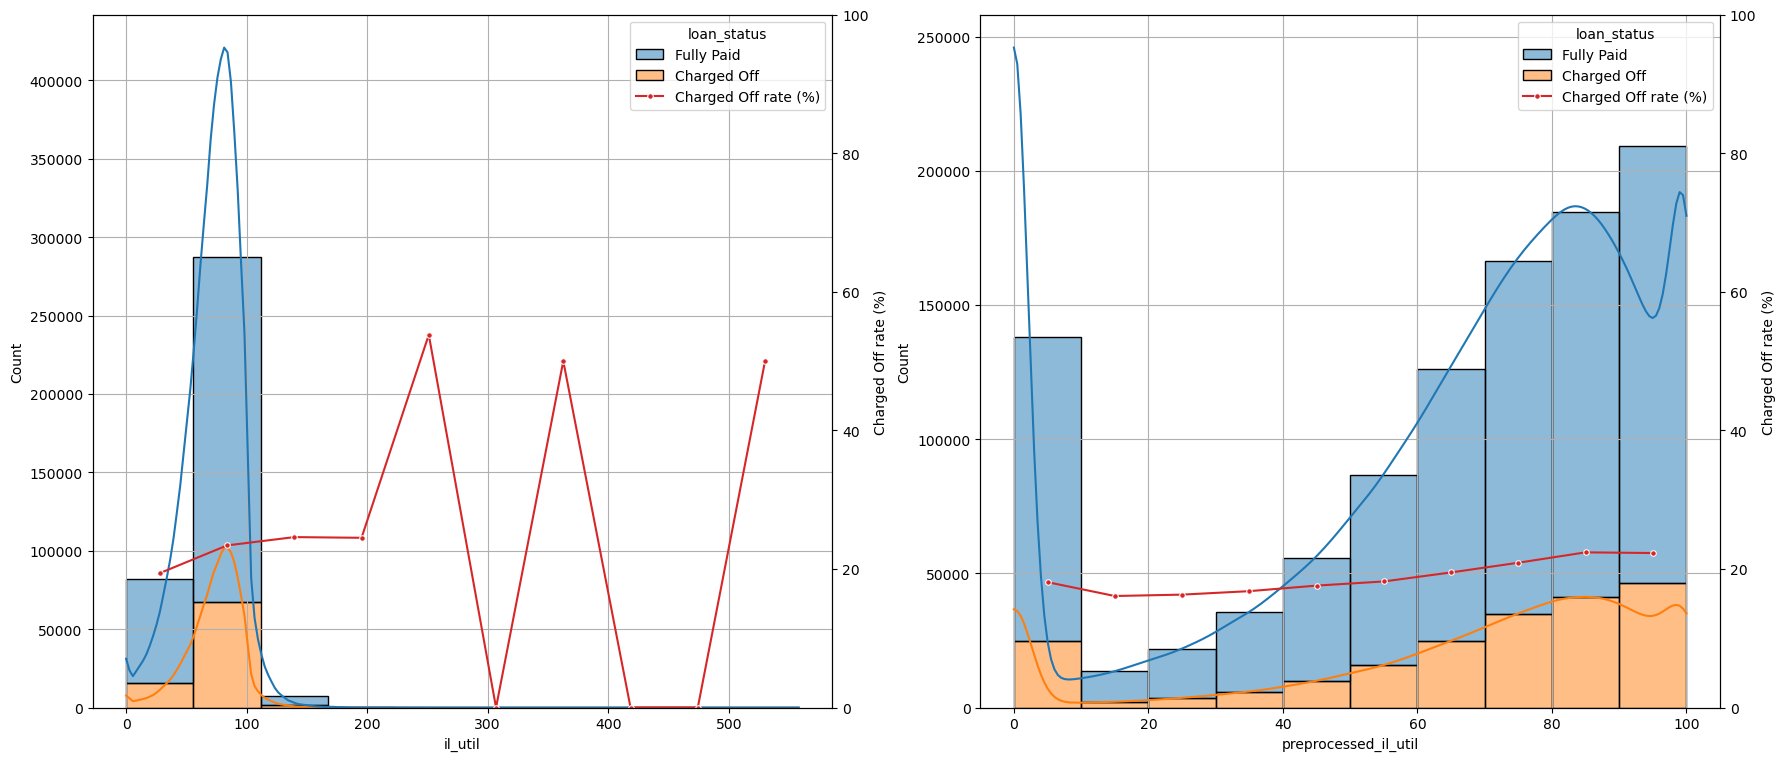

In [55]:
#결측 대체 이전과 비교
EDA_before = pd.concat((X_train, y_train), axis=1)

fig, ax = plt.subplots(1, 2, figsize=(21, 9))
for i, df in enumerate([EDA_before, EDA]):
    sns.histplot(df, x="il_util", hue="loan_status", bins=10, multiple="stack", kde=True, ax=ax[i])
    ax_share = ax[i].twinx()

    fully_paid = np.array([bar.get_height() for bar in ax[i].patches])[len(ax[i].patches) // 2:]
    charged_off = np.array([bar.get_height() for bar in ax[i].patches])[:len(ax[i].patches) // 2]
    sns.lineplot(x=[bar.get_x() + bar.get_width() / 2 for bar in ax[i].patches][:len(ax[i].patches) // 2], y=(charged_off / (fully_paid + charged_off + 1) * 100).round(1), ax=ax_share, color="tab:red", marker="o", markersize=4, label="Charged-Off rate (%)")

    ax[i].grid()
    ax[i].legend(ax[i].get_legend().legend_handles + ax_share.get_legend().legend_handles, ["Fully Paid", "Charged Off", "Charged Off rate (%)"], loc="upper right", title="loan_status")
    if i:
        ax[i].set_xlabel("preprocessed_il_util")
    ax_share.set_ylim(0, 100)
    ax_share.set_ylabel("Charged Off rate (%)")
    ax_share.get_legend().remove()

plt.show()

#### **il_util 처리단계 정리**
1. total_bal_il을 구해보기 위해서 total_bal_ex_mort와 revol_bal사용, 의미에 맞는 식에 대해서 total_bal_il을 계산해 결측 대체
2. total_bal_il == 0 or total_il_high_credit_limit == 0 인 행의 il_util 모두 0으로 변경
3. total_bal_il != np.nan and total_il_high_credit_limit != np.nan 인경우, 의미에 맞는 식에 대해서 il_util을 계산해 결측 대체
4. 나머지 결측치 drop
5. il_util의 max값을 100으로 조정

In [6]:
feature= ['emp_length', 'addr_state', 'term', 'verification_status', 'grade', 'sub_grade', 'purpose', 'fico_range_high', 'fico_range_low', 'dti', 'inq_last_6mths', 'annual_inc', 'loan_amnt', 'revol_util', 'il_util', 'open_rv_24m', 'open_il_24m', 'acc_open_past_24mths', 'open_rv_12m', 'open_il_12m', 'num_tl_op_past_12m', 'open_act_il', 'num_actv_rev_tl']
rel_na = ['revol_bal', 'total_bal_ex_mort', 'total_bal_il', 'total_il_high_credit_limit','total_rev_hi_lim']



In [7]:
EDA_pipe = pd.concat((X_train, y_train), axis=1)

### **util 파이프라인**

In [8]:
EDA_pipe1 =EDA_pipe[feature+rel_na]

In [ ]:
ColumnTransformer()

In [11]:
make_na_table(feature+rel_na, df=EDA_pipe1)

+----------------------------+-------------+-----------+
|           변수명           | 결측치 개수 | 전체 비율 |
+----------------------------+-------------+-----------+
|         emp_length         |    63480    |   5.83%   |
|         addr_state         |      0      |   0.00%   |
|            term            |      0      |   0.00%   |
|    verification_status     |      0      |   0.00%   |
|           grade            |      0      |   0.00%   |
|         sub_grade          |      0      |   0.00%   |
|          purpose           |      0      |   0.00%   |
|      fico_range_high       |      0      |   0.00%   |
|       fico_range_low       |      0      |   0.00%   |
|            dti             |     316     |   0.03%   |
|       inq_last_6mths       |      0      |   0.00%   |
|         annual_inc         |      0      |   0.00%   |
|         loan_amnt          |      0      |   0.00%   |
|         revol_util         |     698     |   0.06%   |
|          il_util           |    712908   

In [9]:
total = feature+rel_na

In [10]:
#total_il_high_credit_limit 는 total_bal_il== 0이면 0으로 대체

In [114]:
from sklearn import set_config
set_config(transform_output="pandas")

class BalImputer(BaseEstimator, TransformerMixin):
    def __init__(self, nan_feature):
        self.nan_feature = nan_feature

    def fit(self, X, y=None):
        self.bal_il = X['total_bal_ex_mort'] - X['revol_bal']
        return self
    
    def transform(self, X): 
        X[self.nan_feature] = X[self.nan_feature].fillna(self.bal_il)
        X[self.nan_feature] = X[self.nan_feature].apply(lambda x: 0 if x < 0 else x)
        return X

class ZeroImputer(BaseEstimator, TransformerMixin):
    def __init__(self, nan_feature, cond):
        self.nan_feature = nan_feature
        self.cond = cond

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X[self.nan_feature] = np.where(X[self.cond] == 0, 0, X[self.nan_feature])
        return X
        
class UtilCalImputer(BaseEstimator, TransformerMixin):
    
    def __init__(self, nan_feature, bal, limit):
        self.nan_feature = nan_feature
        self.bal = bal
        self.limit = limit

    def fit(self, X, y=None):
        self.util = (X[self.bal] / X[self.limit] * 100).round(1)
        return self

    def transform(self, X):
        X[self.nan_feature] = X[self.nan_feature].fillna(self.util)
        X[self.nan_feature] = np.where(X[self.limit] == 0, 0, X[self.nan_feature])
        X[self.nan_feature] = X[self.nan_feature].apply(lambda x: 100 if x > 100 else x)
        return X


util_pre = Pipeline(steps=[
    ('total_bal_impute', ColumnTransformer(transformers=[
                ('simple', SimpleImputer(strategy="median"), ['total_bal_ex_mort'])],
                    remainder='passthrough', verbose_feature_names_out=False)),
    ('total_il_limit_impute', ZeroImputer(nan_feature='total_il_high_credit_limit', cond='total_bal_il')),
    ('total_il_limit_impute2', ColumnTransformer(transformers=[
                ('simple2', SimpleImputer(strategy="median"), ['total_il_high_credit_limit'])],
                    remainder='passthrough', verbose_feature_names_out=False)),
    ('bal_il_impute', BalImputer(nan_feature='total_bal_il')),
    ('il_util_impute', UtilCalImputer(nan_feature='il_util', bal='total_bal_il', limit='total_il_high_credit_limit')),
    ('total_rev_limit_impute', ZeroImputer(nan_feature='total_rev_hi_lim', cond='revol_bal')),
    ('total_rev_limit_impute2', ColumnTransformer(transformers=[
                ('simple2', SimpleImputer(strategy="median"), ['total_rev_hi_lim'])],
                     remainder='passthrough', verbose_feature_names_out=False)),
    ('rev_util_impute', UtilCalImputer(nan_feature='revol_util', bal="revol_bal", limit="total_rev_hi_lim"))

])   

In [115]:
util_pre.fit_transform(EDA_pipe1).isna().sum()

total_rev_hi_lim                   0
total_il_high_credit_limit         0
total_bal_ex_mort                  0
emp_length                     63480
addr_state                         0
term                               0
verification_status                0
grade                              0
sub_grade                          0
purpose                            0
fico_range_high                    0
fico_range_low                     0
dti                              316
inq_last_6mths                     0
annual_inc                         0
loan_amnt                          0
revol_util                         0
il_util                            0
open_rv_24m                   654028
open_il_24m                   654028
acc_open_past_24mths           38350
open_rv_12m                   654028
open_il_12m                   654028
num_tl_op_past_12m             54676
open_act_il                   654028
num_actv_rev_tl                54676
revol_bal                          0
t

### 1-2. rev_util 결측 대체 

In [73]:
rev = ["revol_util", "revol_bal", "total_rev_hi_lim", "loan_status"]
make_na_table(rev)

+------------------+-------------+-----------+
|      변수명      | 결측치 개수 | 전체 비율 |
+------------------+-------------+-----------+
|    revol_util    |     629     |   0.06%   |
|    revol_bal     |      0      |   0.00%   |
| total_rev_hi_lim |     2900    |   0.28%   |
|   loan_status    |      0      |   0.00%   |
+------------------+-------------+-----------+


In [74]:
# 1.reval_bal와 total_rev_util이 0인 경우 -> 0으로 대체
# 2.나머지 행 대체할 방법없고, 적으니 제거
EDA[rev].loc[EDA['revol_util'].isna()]

,revol_util,revol_bal,total_rev_hi_lim,loan_status
637008,NaN,0.0,0.0,Fully Paid
1246912,NaN,0.0,0.0,Fully Paid
1218636,NaN,0.0,0.0,Fully Paid
124559,NaN,0.0,0.0,Fully Paid
917828,NaN,0.0,0.0,Fully Paid
...,...,...,...,...
1258438,NaN,0.0,0.0,Charged Off
550601,NaN,0.0,0.0,Fully Paid
50110,NaN,0.0,0.0,Fully Paid
838984,NaN,484.0,2000.0,Fully Paid


In [75]:
EDA.loc[((EDA['revol_bal']==0) | (EDA['total_rev_hi_lim']==0)), 'revol_util'] = 0

In [76]:
make_na_table(rev)

+------------------+-------------+-----------+
|      변수명      | 결측치 개수 | 전체 비율 |
+------------------+-------------+-----------+
|    revol_util    |     137     |   0.01%   |
|    revol_bal     |      0      |   0.00%   |
| total_rev_hi_lim |     2900    |   0.28%   |
|   loan_status    |      0      |   0.00%   |
+------------------+-------------+-----------+


In [77]:
EDA.revol_util = EDA.revol_util.apply(lambda x: 100 if x > 100 else x)
EDA.loc[EDA.revol_util > 100]

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,loan_status


In [78]:
EDA.dropna(subset='revol_util', inplace=True)

In [79]:
make_na_table(rev)

+------------------+-------------+-----------+
|      변수명      | 결측치 개수 | 전체 비율 |
+------------------+-------------+-----------+
|    revol_util    |      0      |   0.00%   |
|    revol_bal     |      0      |   0.00%   |
| total_rev_hi_lim |     2900    |   0.28%   |
|   loan_status    |      0      |   0.00%   |
+------------------+-------------+-----------+


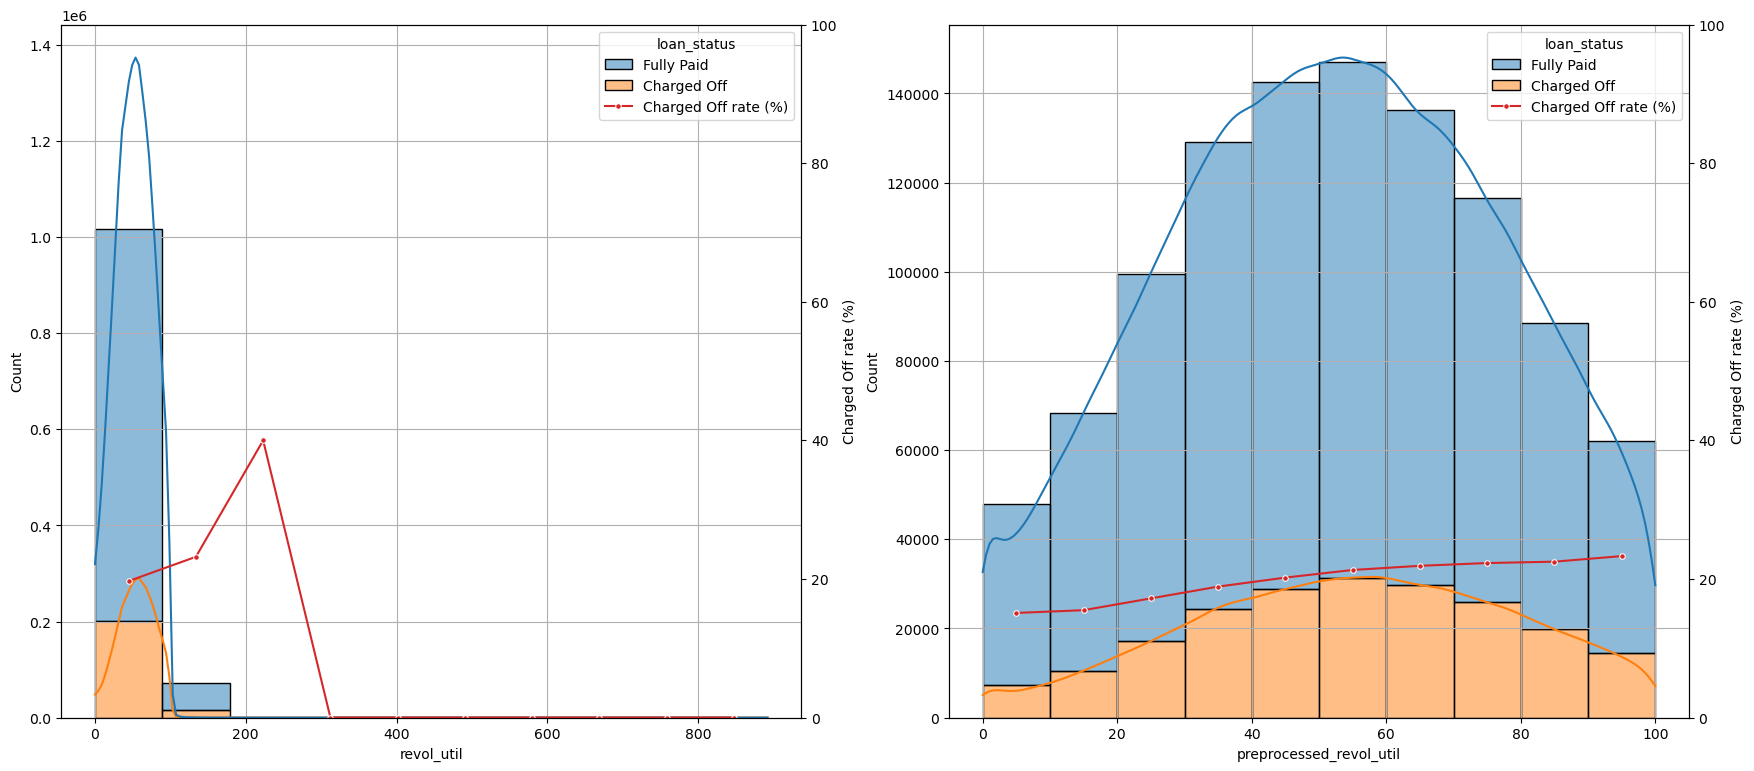

In [80]:
#결측 대체 이전과 비교


fig, ax = plt.subplots(1, 2, figsize=(21, 9))
for i, df in enumerate([EDA_before, EDA]):
    sns.histplot(df, x="revol_util", hue="loan_status", bins=10, multiple="stack", kde=True, ax=ax[i])
    ax_share = ax[i].twinx()

    fully_paid = np.array([bar.get_height() for bar in ax[i].patches])[len(ax[i].patches) // 2:]
    charged_off = np.array([bar.get_height() for bar in ax[i].patches])[:len(ax[i].patches) // 2]
    sns.lineplot(x=[bar.get_x() + bar.get_width() / 2 for bar in ax[i].patches][:len(ax[i].patches) // 2], y=(charged_off / (fully_paid + charged_off + 1) * 100).round(1), ax=ax_share, color="tab:red", marker="o", markersize=4, label="Charged-Off rate (%)")

    ax[i].grid()
    ax[i].legend(ax[i].get_legend().legend_handles + ax_share.get_legend().legend_handles, ["Fully Paid", "Charged Off", "Charged Off rate (%)"], loc="upper right", title="loan_status")
    if i:
        ax[i].set_xlabel("preprocessed_revol_util")
    ax_share.set_ylim(0, 100)
    ax_share.set_ylabel("Charged Off rate (%)")
    ax_share.get_legend().remove()

plt.show()

## 2. 24m(24개월 이내) 계좌 개설 개수 결측 처리 

In [81]:
mths24 = ['acc_open_past_24mths', 'open_rv_24m','open_il_24m']
mo_sin = ['mo_sin_rcnt_tl','mo_sin_rcnt_rev_tl_op', 'mths_since_rcnt_il']

In [82]:
make_na_table(mths24+mo_sin)

+-----------------------+-------------+-----------+
|         변수명        | 결측치 개수 | 전체 비율 |
+-----------------------+-------------+-----------+
|  acc_open_past_24mths |      0      |   0.00%   |
|      open_rv_24m      |    602182   |   58.03%  |
|      open_il_24m      |    602182   |   58.03%  |
|     mo_sin_rcnt_tl    |     2900    |   0.28%   |
| mo_sin_rcnt_rev_tl_op |     2900    |   0.28%   |
|   mths_since_rcnt_il  |    613759   |   59.14%  |
+-----------------------+-------------+-----------+


### idea1 : 최근 대출 계좌 경과 개월수 관련 특성 이용해서 최근 경과개월 수가 24초과이면 해당 결측값 0으로 대체

- 'mo_sin_rcnt_tl' : 가장 최근 계좌 개설 경과 개월 수
- 'mo_sin_rcnt_rev_tl_op' : 최근 리볼빙_계좌 개설 경과 개월 수
- 'mths_since_rcnt_il' : 최근 할부_계좌 개설 경과 개월 수

In [83]:
# 아이디어 논리검증
# 레볼빙 계좌개설 경과개월 24 초과 & 24개월안에 리볼빙 개설 개수 not na & 개수란에 0이 아닌 값 : 없음을 확인함.

len(EDA[mths24+mo_sin][(EDA['mo_sin_rcnt_rev_tl_op']>24) & (EDA['open_rv_24m'].notna()) & (EDA['open_rv_24m']!=0)])

0

In [84]:
#il
len(EDA[mths24+mo_sin][(EDA['mths_since_rcnt_il']>24) & (EDA['open_il_24m'].notna()) & (EDA['open_il_24m']!=0)])

0

In [85]:
#total
#아이디어 논리 이상치
len(EDA[mths24+mo_sin][(EDA['mo_sin_rcnt_tl']>24) & (EDA['mo_sin_rcnt_tl'].notna()) & (EDA['mo_sin_rcnt_tl']!=0)])

40589

In [86]:
#결측치 654028중 82334결측대체 가능
len(EDA[mths24][(EDA['mo_sin_rcnt_rev_tl_op']>24) & (EDA['open_rv_24m'].isna())])

82279

In [87]:
# rev 조건에 해당하는 값을 0으로 대체
EDA.loc[(EDA['mo_sin_rcnt_rev_tl_op'] > 24) & (EDA['open_rv_24m'].isna()), 'open_rv_24m'] = 0

In [88]:
#il는 해당 아이디어에 해당되는 행 없음
len(EDA[mths24][(EDA['mths_since_rcnt_il']>24) & (EDA['open_il_24m'].isna())])

0

In [89]:
make_na_table(mths24+mo_sin)

+-----------------------+-------------+-----------+
|         변수명        | 결측치 개수 | 전체 비율 |
+-----------------------+-------------+-----------+
|  acc_open_past_24mths |      0      |   0.00%   |
|      open_rv_24m      |    519903   |   50.10%  |
|      open_il_24m      |    602182   |   58.03%  |
|     mo_sin_rcnt_tl    |     2900    |   0.28%   |
| mo_sin_rcnt_rev_tl_op |     2900    |   0.28%   |
|   mths_since_rcnt_il  |    613759   |   59.14%  |
+-----------------------+-------------+-----------+


### 2. idea2 : 'acc_open_past_24mths'= 'open_rv_24m'+'open_il_24m' 수식 이용
- **rv, il중 한쪽만 결측값을 가질때 수식으로 대체**

In [90]:
EDA[mths24].isna().any(axis=1).sum()

602182

In [91]:
#total_bal_il이 결측이 아닌 것중 93% 이상의 행이 위 수식에 따르고 있다.

len_24 = len(EDA[mths24])
ex_na = EDA[mths24].isna().any(axis=1).sum()
equal = len(EDA[mths24][EDA['acc_open_past_24mths'] == (EDA['open_rv_24m']+EDA['open_il_24m'])])
outlier = (len_24-ex_na)-(equal)

print(f'총 길이: {len_24}')
print(f'결측값: {ex_na}')
print(f'논리에 맞는 수: {equal}')
print(f'값이 있는 것 중에 논리의 맞지 않는 경우: {outlier}')
print("값이 있는 것 중 논리 맞지 않는 비율:", round(outlier / (len_24-ex_na) * 100, 2),'%')

총 길이: 1037788
결측값: 602182
논리에 맞는 수: 335248
값이 있는 것 중에 논리의 맞지 않는 경우: 100358
값이 있는 것 중 논리 맞지 않는 비율: 23.04 %


In [92]:
#mort_acc 생각해보기
EDA[mths24+['mort_acc']][EDA['acc_open_past_24mths'] != (EDA['open_rv_24m']+EDA['open_il_24m'])].dropna().sample(20)

,acc_open_past_24mths,open_rv_24m,open_il_24m,mort_acc
973906,4.0,0.0,2.0,7.0
487427,10.0,7.0,2.0,4.0
605148,13.0,9.0,3.0,3.0
571285,10.0,6.0,3.0,4.0
540712,15.0,12.0,2.0,2.0
551697,5.0,0.0,4.0,3.0
636390,2.0,0.0,1.0,3.0
382680,5.0,3.0,1.0,1.0
379315,3.0,2.0,0.0,3.0
1212097,9.0,5.0,1.0,8.0


In [93]:
# 오차범위 +-1을 고려하여 조건을 설정하고, 해당 조건을 만족하는 행의 개수 세기
equal_range = len(EDA[mths24][
    (EDA['acc_open_past_24mths'] >= (EDA['open_rv_24m'] + EDA['open_il_24m']) - 1) &
    (EDA['acc_open_past_24mths'] <= (EDA['open_rv_24m'] + EDA['open_il_24m']) + 1)
])
outlier = (len_24-ex_na)-(equal_range)

print(f'논리에 맞는 수: {equal_range}')
print(f'값이 있는 것 중에 논리의 맞지 않는 경우: {outlier}')
print("값이 있는 것 중 논리 맞지 않는 비율:", round(outlier / (len_24-ex_na) * 100, 2),'%')

논리에 맞는 수: 413897
값이 있는 것 중에 논리의 맞지 않는 경우: 21709
값이 있는 것 중 논리 맞지 않는 비율: 4.98 %


In [94]:
# 오차범위 +-2을 고려하여 조건을 설정하고, 해당 조건을 만족하는 행의 개수 세기
equal_range = len(EDA[mths24][
    (EDA['acc_open_past_24mths'] >= (EDA['open_rv_24m'] + EDA['open_il_24m']) - 2) &
    (EDA['acc_open_past_24mths'] <= (EDA['open_rv_24m'] + EDA['open_il_24m']) + 2)
])
outlier = (len_24-ex_na)-(equal_range)

print(f'논리에 맞는 수: {equal_range}')
print(f'값이 있는 것 중에 논리의 맞지 않는 경우: {outlier}')
print("값이 있는 것 중 논리 맞지 않는 비율:", round(outlier / (len_24-ex_na) * 100, 2),'%')

논리에 맞는 수: 431998
값이 있는 것 중에 논리의 맞지 않는 경우: 3608
값이 있는 것 중 논리 맞지 않는 비율: 0.83 %


In [95]:
#1. il 대체: open_rev_24m가 결측이 아닐때 : 0개
len(EDA[mths24][(EDA['acc_open_past_24mths'].notna()) & (EDA['open_rv_24m'].notna()) & (EDA['open_il_24m'].isna())])

82279

In [96]:
EDA.loc[EDA['open_il_24m'].isna(), 'open_il_24m'] = EDA.loc[EDA['open_il_24m'].isna(), 'acc_open_past_24mths'] - EDA.loc[EDA['open_il_24m'].isna(), 'open_rv_24m']

In [97]:
#2. rev 대체: open_il_24m가 결측이 아닐때 : 0개
len(EDA[mths24][(EDA['acc_open_past_24mths'].notna()) & (EDA['open_rv_24m'].isna()) & (EDA['open_il_24m'].notna())])

0

In [98]:
make_na_table(mths24)

+----------------------+-------------+-----------+
|        변수명        | 결측치 개수 | 전체 비율 |
+----------------------+-------------+-----------+
| acc_open_past_24mths |      0      |   0.00%   |
|     open_rv_24m      |    519903   |   50.10%  |
|     open_il_24m      |    519903   |   50.10%  |
+----------------------+-------------+-----------+


In [99]:
EDA[mths24][(EDA['acc_open_past_24mths'].isna()) & (EDA['open_rv_24m'].notna())]

,acc_open_past_24mths,open_rv_24m,open_il_24m


In [100]:
EDA[mths24][(EDA['acc_open_past_24mths'].isna()) & (EDA['open_il_24m'].notna())]

,acc_open_past_24mths,open_rv_24m,open_il_24m


In [101]:
#> acc_open_past_24mths의 결측치 전부 mo_sin_rcnt_tl가 na일 때 발생.
# >> 개설여부가 없다는 건데 total_acc에는 있음
# >> **즉, 패턴에 의한 결측이 아닌 무작위 결측으로 사료됨**

# - acc_open_past_24mths 결측치 제거 (전체 비율의 0.08%이므로 훈련데이터 적은 손실로)
#total 24mths 대체할 수 있는 방법이 없으므로 해당 결측이 있는 행 삭제

EDA.dropna(subset='acc_open_past_24mths', inplace=True)

In [102]:
make_na_table(mths24)

+----------------------+-------------+-----------+
|        변수명        | 결측치 개수 | 전체 비율 |
+----------------------+-------------+-----------+
| acc_open_past_24mths |      0      |   0.00%   |
|     open_rv_24m      |    519903   |   50.10%  |
|     open_il_24m      |    519903   |   50.10%  |
+----------------------+-------------+-----------+


### 3.idea3 
1. total_24==0이면 open_il_24m, open_rv_24m 0으로 채우기
2. total_24!=0이면 open_il_24m, open_rv_24m 나눠서 값 가지기 

In [103]:
#1. total_24==0이면 'open_rv_24m', 'open_il_24m' 0으로 채우기

EDA.loc[(EDA['acc_open_past_24mths'] == 0) & (EDA['open_rv_24m'].isna()), 'open_rv_24m'] = 0 
EDA.loc[(EDA['acc_open_past_24mths'] == 0) & (EDA['open_il_24m'].isna()), 'open_il_24m'] = 0 

In [104]:
make_na_table(mths24)

+----------------------+-------------+-----------+
|        변수명        | 결측치 개수 | 전체 비율 |
+----------------------+-------------+-----------+
| acc_open_past_24mths |      0      |   0.00%   |
|     open_rv_24m      |    519523   |   50.06%  |
|     open_il_24m      |    519523   |   50.06%  |
+----------------------+-------------+-----------+


In [105]:
#2. total_24!=0이면 'open_rv_24m', 'open_il_24m' 나눠서 값 가지기 

EDA.loc[(EDA['acc_open_past_24mths'] != 0) & (EDA['open_rv_24m'].isna()),'open_rv_24m'] = EDA.loc[(EDA['acc_open_past_24mths'] != 0) & (EDA['open_rv_24m'].isna()),'acc_open_past_24mths'] // 2
EDA.loc[(EDA['acc_open_past_24mths'] != 0) & (EDA['open_il_24m'].isna()),'open_il_24m'] = EDA.loc[(EDA['acc_open_past_24mths'] != 0) & (EDA['open_il_24m'].isna()),'acc_open_past_24mths'] // 2

In [106]:
make_na_table(mths24)

+----------------------+-------------+-----------+
|        변수명        | 결측치 개수 | 전체 비율 |
+----------------------+-------------+-----------+
| acc_open_past_24mths |      0      |   0.00%   |
|     open_rv_24m      |      0      |   0.00%   |
|     open_il_24m      |      0      |   0.00%   |
+----------------------+-------------+-----------+


### 대체 전후 비교

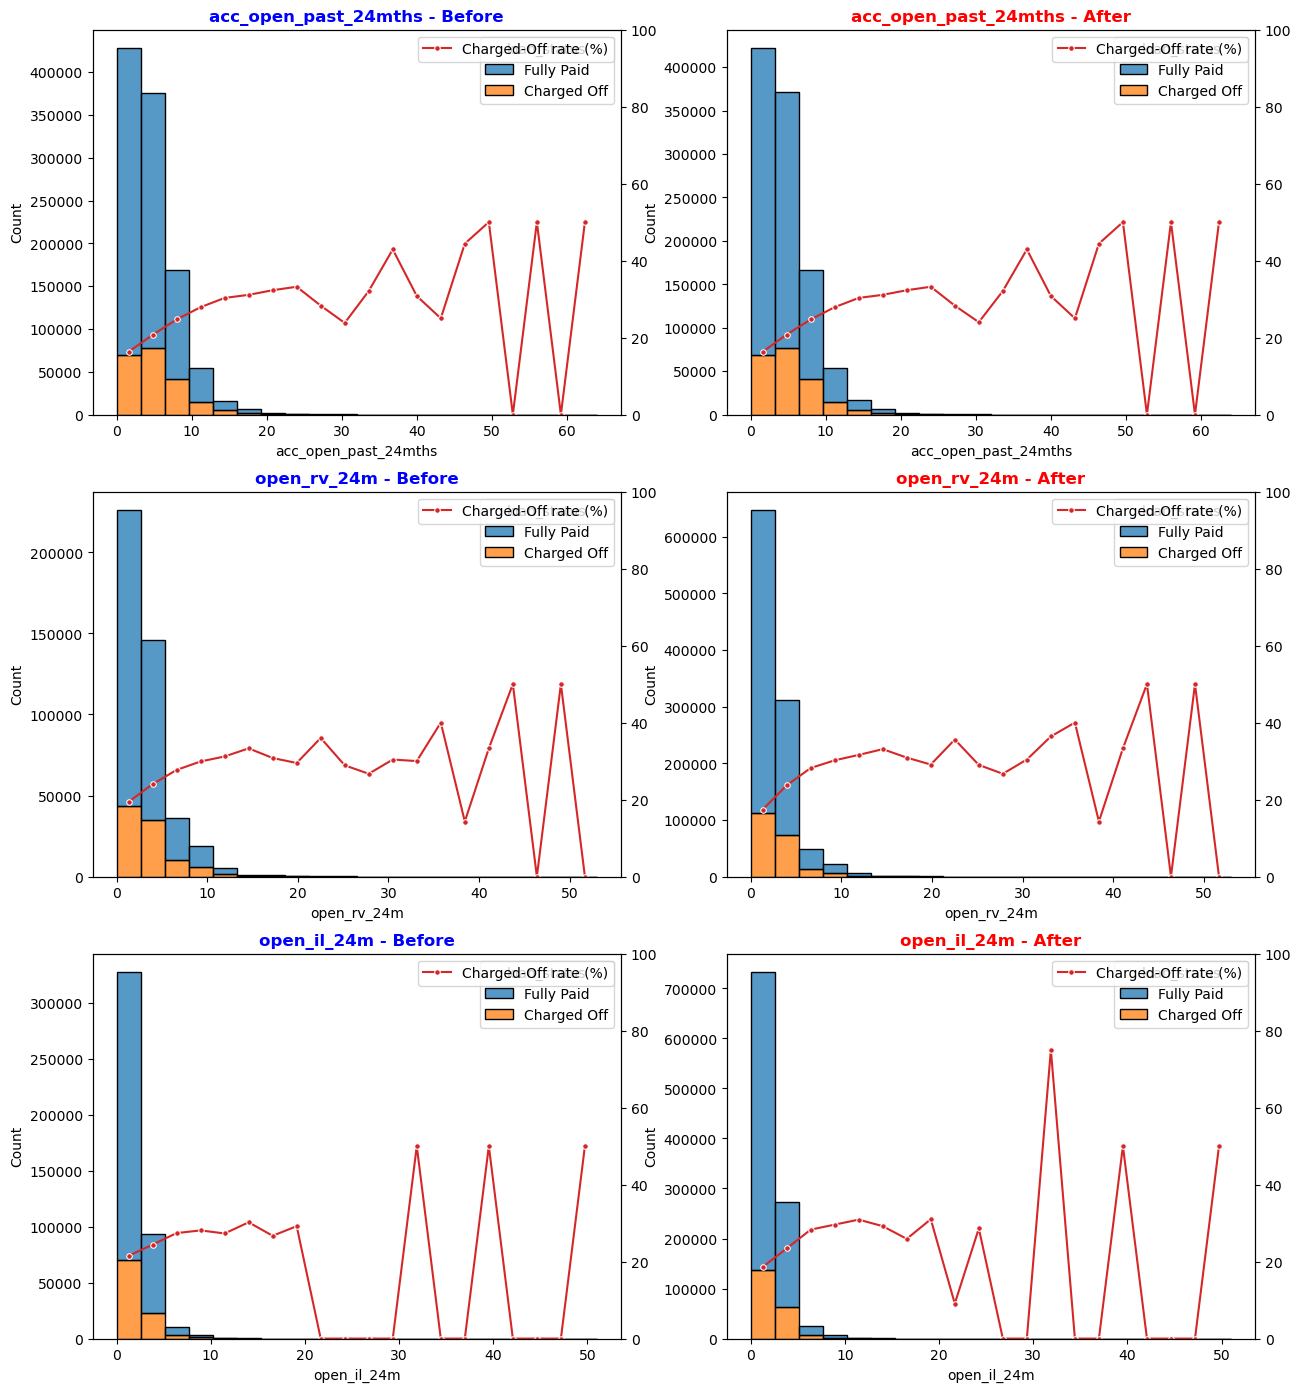

In [107]:
fig, ax = plt.subplots(3, 2, figsize=(15, 17))

for idx, col in enumerate(mths24):
    # 첫 번째 열의 그래프 그리기 Before
    ax1 = sns.histplot(EDA_before, x=col, hue="loan_status", bins=20, multiple="stack", ax=ax[idx, 0])
    charged_off_before = np.array([bar.get_height() for bar in ax1.patches])[:len(ax1.patches) // 2]
    fully_paid_before = np.array([bar.get_height() for bar in ax1.patches])[len(ax1.patches) // 2:]
    ax[idx, 0].set_title(f'{col} - Before', color='blue', fontweight='bold')
    ax2 = ax[idx, 0].twinx()
    ax2.set_ylim(0, 100)
    sns.lineplot(x=[bar.get_x() + bar.get_width() / 2 for bar in ax1.patches][:len(ax1.patches) // 2], 
                 y=(charged_off_before / (fully_paid_before + charged_off_before + 1) * 100).round(1), 
                 ax=ax2, color="tab:red", marker="o", markersize=4, label="Charged-Off rate (%)")
    
    # 두 번째 열의 그래프 그리기 After
    ax3 = sns.histplot(EDA, x=col, hue="loan_status", bins=20, multiple="stack", ax=ax[idx, 1])
    charged_off = np.array([bar.get_height() for bar in ax3.patches])[:len(ax3.patches) // 2]
    fully_paid = np.array([bar.get_height() for bar in ax3.patches])[len(ax3.patches) // 2:]
    ax[idx, 1].set_title(f'{col} - After', color='red', fontweight='bold')

    ax4 = ax[idx, 1].twinx()
    ax4.set_ylim(0, 100)
    sns.lineplot(x=[bar.get_x() + bar.get_width() / 2 for bar in ax3.patches][:len(ax3.patches) // 2], 
                 y=(charged_off / (fully_paid + charged_off + 1) * 100).round(1), 
                 ax=ax4, color="tab:red", marker="o", markersize=4, label="Charged-Off rate (%)")

In [108]:
EDA_before[mths24].describe()

,acc_open_past_24mths,open_rv_24m,open_il_24m
count,1.051351e+06,435673.000000,435673.000000
mean,4.694307e+00,3.007221,1.744203
std,3.190705e+00,2.703640,1.689019
min,0.000000e+00,0.000000,0.000000
25%,2.000000e+00,1.000000,1.000000
50%,4.000000e+00,2.000000,1.000000
75%,6.000000e+00,4.000000,2.000000
max,6.400000e+01,53.000000,51.000000


> 동등하게 나누어 채우면서 rv와 il간의 특성차이가 옅어짐

In [109]:
pd.set_option('display.float_format', '{:.6f}'.format)
EDA[mths24].describe()

,acc_open_past_24mths,open_rv_24m,open_il_24m
count,1037788.000000,1037788.000000,1037788.000000
mean,4.700813,2.369728,1.955453
std,3.195766,2.190154,1.606134
min,0.000000,0.000000,0.000000
25%,2.000000,1.000000,1.000000
50%,4.000000,2.000000,2.000000
75%,6.000000,3.000000,3.000000
max,64.000000,53.000000,51.000000


In [110]:
EDA_before[mths24+[target]].groupby(target).median()

,acc_open_past_24mths,open_rv_24m,open_il_24m
loan_status,,,
Charged Off,5.000000,3.000000,1.000000
Fully Paid,4.000000,2.000000,1.000000


In [111]:
EDA[mths24+[target]].groupby(target).median()

,acc_open_past_24mths,open_rv_24m,open_il_24m
loan_status,,,
Charged Off,5.000000,2.000000,2.000000
Fully Paid,4.000000,2.000000,2.000000


## 3. 12m(24개월 이내) 계좌 개설 개수 결측 처리 

In [112]:
mths12 = ['num_tl_op_past_12m', 'open_rv_12m','open_il_12m']
mo_sin = ['mo_sin_rcnt_tl','mo_sin_rcnt_rev_tl_op', 'mths_since_rcnt_il']

In [113]:
make_na_table(mths12)

+--------------------+-------------+-----------+
|       변수명       | 결측치 개수 | 전체 비율 |
+--------------------+-------------+-----------+
| num_tl_op_past_12m |     2900    |   0.28%   |
|    open_rv_12m     |    602182   |   58.03%  |
|    open_il_12m     |    602182   |   58.03%  |
+--------------------+-------------+-----------+


### idea1 : 최근 대출 계좌 경과 개월수 관련 특성 이용해서 최근 경과개월 수가 24초과이면 해당 결측값 0으로 대체

- 'mo_sin_rcnt_tl' : 가장 최근 계좌 개설 경과 개월 수
- 'mo_sin_rcnt_rev_tl_op' : 최근 리볼빙_계좌 개설 경과 개월 수
- 'mths_since_rcnt_il' : 최근 할부_계좌 개설 경과 개월 수

In [114]:
EDA.loc[EDA['mo_sin_rcnt_rev_tl_op']>12, 'open_rv_12m'] = 0 #리볼빙
EDA.loc[EDA['mths_since_rcnt_il']>12, 'open_il_12m'] = 0 #할부
EDA.loc[EDA['mo_sin_rcnt_tl']>12, 'num_tl_op_past_12m'] = 0 #전체

In [115]:
make_na_table(mths12)

+--------------------+-------------+-----------+
|       변수명       | 결측치 개수 | 전체 비율 |
+--------------------+-------------+-----------+
| num_tl_op_past_12m |     2900    |   0.28%   |
|    open_rv_12m     |    401760   |   38.71%  |
|    open_il_12m     |    602182   |   58.03%  |
+--------------------+-------------+-----------+


### 2. idea2 : 'num_tl_op_past_12m '= 'open_rv_12m'+'open_il_12m' 수식 이용
- **rv, il중 한쪽만 결측값을 가질때 수식으로 대체**

In [116]:
EDA.loc[(EDA['num_tl_op_past_12m']==0), 'open_rv_12m'] = 0
EDA.loc[(EDA['num_tl_op_past_12m']==0), 'open_il_12m'] = 0

In [117]:
make_na_table(mths12)

+--------------------+-------------+-----------+
|       변수명       | 결측치 개수 | 전체 비율 |
+--------------------+-------------+-----------+
| num_tl_op_past_12m |     2900    |   0.28%   |
|    open_rv_12m     |    401718   |   38.71%  |
|    open_il_12m     |    497098   |   47.90%  |
+--------------------+-------------+-----------+


In [118]:
#1. il 대체: open_rev_12m가 결측이 아닐때 : 0개
print(len(EDA[mths12][(EDA['num_tl_op_past_12m'].notna()) & (EDA['open_rv_12m'].notna()) & (EDA['open_il_12m'].isna())]))
#2. rev 대체: open_il_12m가 결측이 아닐때 : 0개
print(len(EDA[mths12][(EDA['num_tl_op_past_12m'].notna()) & (EDA['open_rv_12m'].isna()) & (EDA['open_il_12m'].notna())]))

95380
0


In [119]:
mask = (EDA['num_tl_op_past_12m'].notna()) & (EDA['open_rv_12m'].notna()) & (EDA['open_il_12m'].isna())
EDA.loc[mask, 'open_il_12m'] = EDA.loc[mask, 'num_tl_op_past_12m'] - EDA.loc[mask, 'open_rv_12m']

In [120]:
make_na_table(mths12)

+--------------------+-------------+-----------+
|       변수명       | 결측치 개수 | 전체 비율 |
+--------------------+-------------+-----------+
| num_tl_op_past_12m |     2900    |   0.28%   |
|    open_rv_12m     |    401718   |   38.71%  |
|    open_il_12m     |    401718   |   38.71%  |
+--------------------+-------------+-----------+


In [121]:
#모두 같은 위치에 결측치 있음으로 변화
na_index_equal = all(EDA['open_rv_12m'].isna() == EDA['open_il_12m'].isna())
na_index_equal

True

### idea3. 두개 나눠서 값 가져가기

In [122]:
#2. total_24!=0이면 'open_rv_24m', 'open_il_24m' 나눠서 값 가지기 

EDA.loc[(EDA['num_tl_op_past_12m'] != 0) & (EDA['open_rv_12m'].isna()),'open_rv_12m'] = EDA.loc[(EDA['num_tl_op_past_12m'] != 0) & (EDA['open_rv_12m'].isna()),'num_tl_op_past_12m'] // 2
EDA.loc[(EDA['num_tl_op_past_12m'] != 0) & (EDA['open_il_12m'].isna()),'open_il_12m'] = EDA.loc[(EDA['num_tl_op_past_12m'] != 0) & (EDA['open_il_12m'].isna()),'num_tl_op_past_12m'] // 2

In [123]:
make_na_table(mths12+mo_sin)

+-----------------------+-------------+-----------+
|         변수명        | 결측치 개수 | 전체 비율 |
+-----------------------+-------------+-----------+
|   num_tl_op_past_12m  |     2900    |   0.28%   |
|      open_rv_12m      |     2900    |   0.28%   |
|      open_il_12m      |     2900    |   0.28%   |
|     mo_sin_rcnt_tl    |     2900    |   0.28%   |
| mo_sin_rcnt_rev_tl_op |     2900    |   0.28%   |
|   mths_since_rcnt_il  |    613759   |   59.14%  |
+-----------------------+-------------+-----------+


In [124]:
#모두 같은 위치에 결측치 있음으로 변화
na_index_equal = all(EDA['num_tl_op_past_12m'].isna() == EDA['mo_sin_rcnt_tl'].isna())
na_index_equal

True

In [125]:
EDA.dropna(subset='num_tl_op_past_12m', axis=0, inplace=True)

In [126]:
make_na_table(mths12+mo_sin)

+-----------------------+-------------+-----------+
|         변수명        | 결측치 개수 | 전체 비율 |
+-----------------------+-------------+-----------+
|   num_tl_op_past_12m  |      0      |   0.00%   |
|      open_rv_12m      |      0      |   0.00%   |
|      open_il_12m      |      0      |   0.00%   |
|     mo_sin_rcnt_tl    |      0      |   0.00%   |
| mo_sin_rcnt_rev_tl_op |      0      |   0.00%   |
|   mths_since_rcnt_il  |    610859   |   59.03%  |
+-----------------------+-------------+-----------+


### 대체 전후 비교

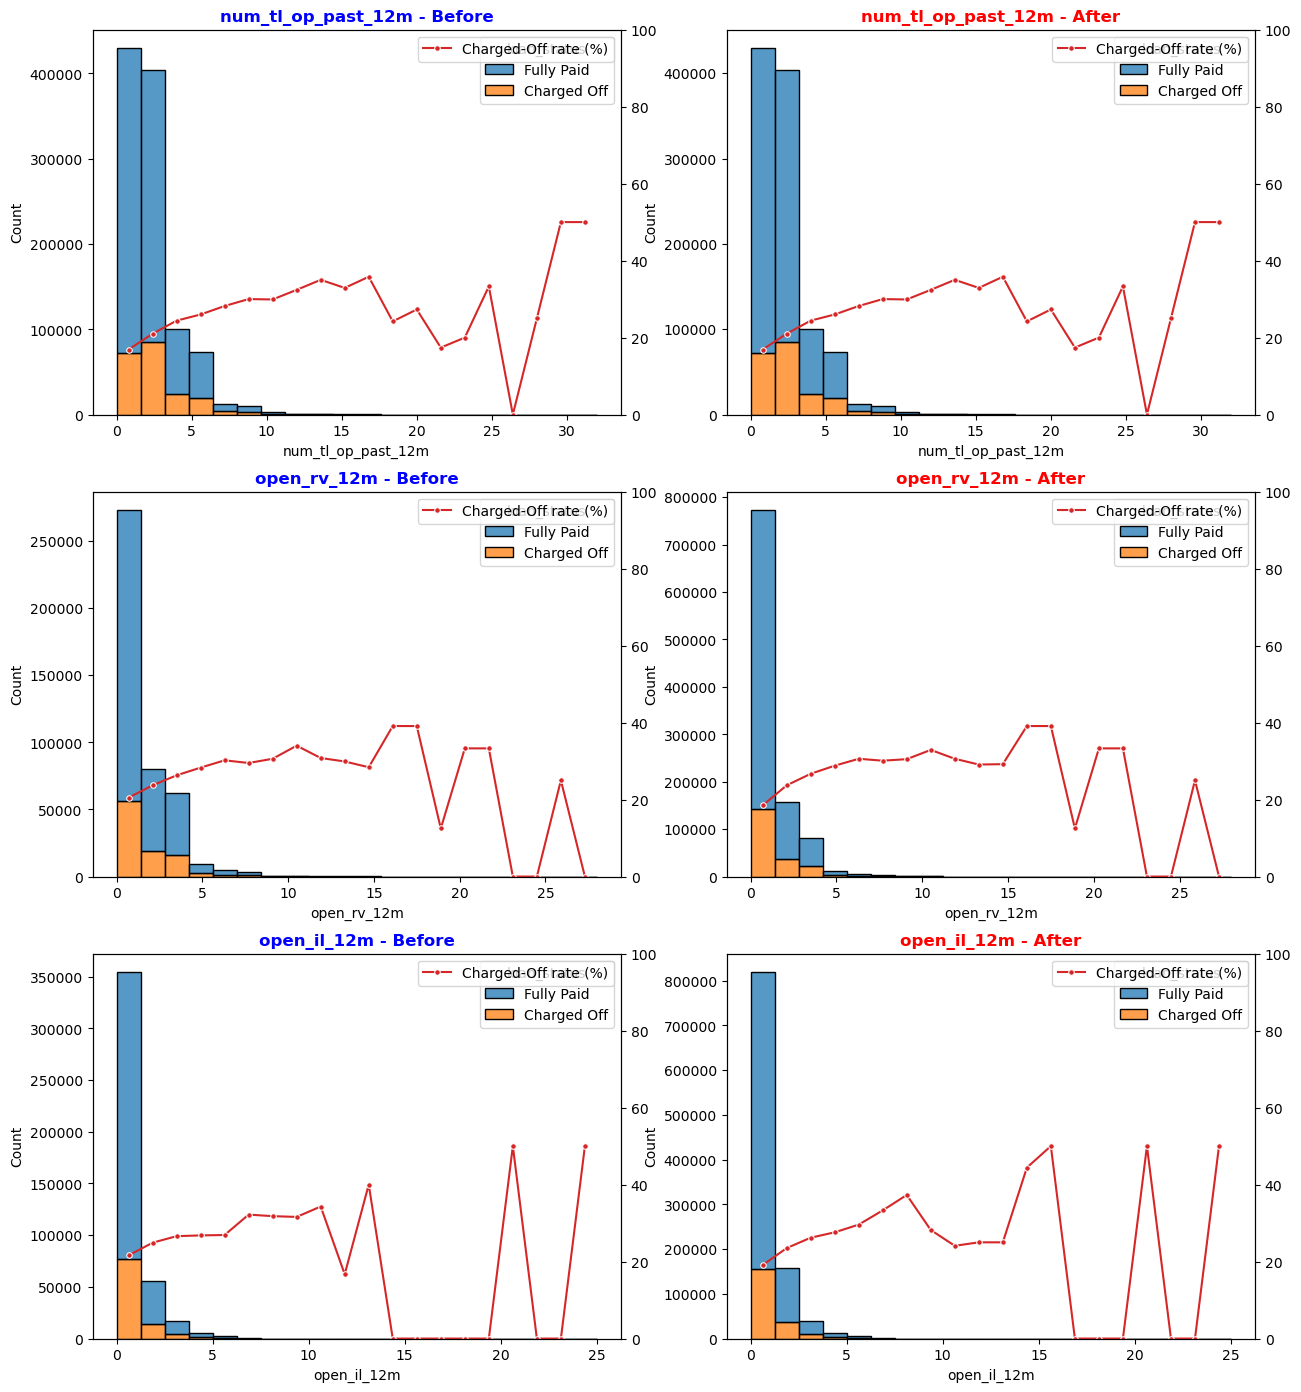

In [127]:
fig, ax = plt.subplots(3, 2, figsize=(15, 17))

for idx, col in enumerate(mths12):
    # 첫 번째 열의 그래프 그리기 Before
    ax1 = sns.histplot(EDA_before, x=col, hue="loan_status", bins=20, multiple="stack", ax=ax[idx, 0])
    charged_off_before = np.array([bar.get_height() for bar in ax1.patches])[:len(ax1.patches) // 2]
    fully_paid_before = np.array([bar.get_height() for bar in ax1.patches])[len(ax1.patches) // 2:]
    ax[idx, 0].set_title(f'{col} - Before', color='blue', fontweight='bold')
    ax2 = ax[idx, 0].twinx()
    ax2.set_ylim(0, 100)
    sns.lineplot(x=[bar.get_x() + bar.get_width() / 2 for bar in ax1.patches][:len(ax1.patches) // 2], 
                 y=(charged_off_before / (fully_paid_before + charged_off_before + 1) * 100).round(1), 
                 ax=ax2, color="tab:red", marker="o", markersize=4, label="Charged-Off rate (%)")
    
    # 두 번째 열의 그래프 그리기 After
    ax3 = sns.histplot(EDA, x=col, hue="loan_status", bins=20, multiple="stack", ax=ax[idx, 1])
    charged_off = np.array([bar.get_height() for bar in ax3.patches])[:len(ax3.patches) // 2]
    fully_paid = np.array([bar.get_height() for bar in ax3.patches])[len(ax3.patches) // 2:]
    ax[idx, 1].set_title(f'{col} - After', color='red', fontweight='bold')

    ax4 = ax[idx, 1].twinx()
    ax4.set_ylim(0, 100)
    sns.lineplot(x=[bar.get_x() + bar.get_width() / 2 for bar in ax3.patches][:len(ax3.patches) // 2], 
                 y=(charged_off / (fully_paid + charged_off + 1) * 100).round(1), 
                 ax=ax4, color="tab:red", marker="o", markersize=4, label="Charged-Off rate (%)")

In [128]:
EDA_before[mths12].describe()

,num_tl_op_past_12m,open_rv_12m,open_il_12m
count,1035025.000000,435673.000000,435673.000000
mean,2.179856,1.421883,0.777303
std,1.846940,1.577191,0.995708
min,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000
50%,2.000000,1.000000,1.000000
75%,3.000000,2.000000,1.000000
max,32.000000,28.000000,25.000000


In [129]:
EDA[mths12].describe()

,num_tl_op_past_12m,open_rv_12m,open_il_12m
count,1034888.000000,1034888.000000,1034888.000000
mean,2.179998,1.020629,0.890281
std,1.846955,1.273302,0.964468
min,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000
50%,2.000000,1.000000,1.000000
75%,3.000000,2.000000,1.000000
max,32.000000,28.000000,25.000000


### **mths 파이프라인**

In [34]:
print(feature+rel_na+mo_sin)num_tl_op_past_12m

['emp_length', 'addr_state', 'term', 'verification_status', 'grade', 'sub_grade', 'purpose', 'fico_range_high', 'fico_range_low', 'dti', 'inq_last_6mths', 'annual_inc', 'loan_amnt', 'revol_util', 'il_util', 'open_rv_24m', 'open_il_24m', 'acc_open_past_24mths', 'open_rv_12m', 'open_il_12m', 'num_tl_op_past_12m', 'open_act_il', 'num_actv_rev_tl', 'revol_bal', 'total_bal_ex_mort', 'total_bal_il', 'total_il_high_credit_limit', 'total_rev_hi_lim', 'mo_sin_rcnt_tl', 'mo_sin_rcnt_rev_tl_op', 'mths_since_rcnt_il']


In [38]:
EDA_pipe1 =EDA_pipe[feature+rel_na+mo_sin]

In [36]:
mo_sin = ['mo_sin_rcnt_tl','mo_sin_rcnt_rev_tl_op', 'mths_since_rcnt_il']

In [39]:
make_na_table(EDA_pipe1)

+----------------------------+-------------+-----------+
|           변수명           | 결측치 개수 | 전체 비율 |
+----------------------------+-------------+-----------+
|         emp_length         |    63480    |   5.83%   |
|         addr_state         |      0      |   0.00%   |
|            term            |      0      |   0.00%   |
|    verification_status     |      0      |   0.00%   |
|           grade            |      0      |   0.00%   |
|         sub_grade          |      0      |   0.00%   |
|          purpose           |      0      |   0.00%   |
|      fico_range_high       |      0      |   0.00%   |
|       fico_range_low       |      0      |   0.00%   |
|            dti             |     316     |   0.03%   |
|       inq_last_6mths       |      0      |   0.00%   |
|         annual_inc         |      0      |   0.00%   |
|         loan_amnt          |      0      |   0.00%   |
|         revol_util         |     698     |   0.06%   |
|          il_util           |    712908   

In [42]:
#아이디어 1단계
class NZero_Imputer(BaseEstimator, TransformerMixin):
    def __init__(self, n, nan_feature, cond):
        self.nan_feature = nan_feature
        self.cond = cond
        self.n = n

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X[self.nan_feature] = np.where(X[self.cond] > self.n, 0, X[self.nan_feature])
        return X

#아이디어 2단계
class CalImputer(BaseEstimator, TransformerMixin):
    
    def __init__(self, nan_feature, total, another):
        self.nan_feature = nan_feature
        self.total = total
        self.another = another

    def fit(self, X, y=None):
        self.value = X[self.total] - X[self.another] 
        return self

    def transform(self, X):
        X[self.nan_feature] = X[self.nan_feature].fillna(self.value)
        X[self.nan_feature] = np.where(X[self.total] == 0, 0, X[self.nan_feature])
        return X

#아이디어 3단계
class Devide_Imputer(BaseEstimator, TransformerMixin):
    
    def __init__(self, nan_feature, total, another):
        self.nan_feature = nan_feature
        self.total = total
        self.another = another

    def fit(self, X, y=None):
        self.value = (X[self.total] // 2)
        return self

    def transform(self, X):
        X[self.nan_feature] = X[self.nan_feature].fillna(self.value)
        X[self.another] = X[self.another].fillna(self.value)
        return X

mths_pre = Pipeline(steps=[
    ('total_mths24_impute', ColumnTransformer(transformers=[
                ('simple', SimpleImputer(strategy="median"), ['acc_open_past_24mths'])],
                    remainder='passthrough', verbose_feature_names_out=False)),
    ('rv24_zero', NZero_Imputer(n=24, nan_feature='open_rv_24m', cond='mo_sin_rcnt_rev_tl_op')),
    ('il24_zero', NZero_Imputer(n=24, nan_feature='open_il_24m', cond='mths_since_rcnt_il')),
    ('rv24_impute1', CalImputer(nan_feature='open_rv_24m', total='acc_open_past_24mths', another='open_il_24m')),
    ('il24_impute1', CalImputer(nan_feature='open_il_24m', total='acc_open_past_24mths', another='open_rv_24m')),
    ('rv_il_24_impute2', Devide_Imputer(nan_feature='open_rv_24m', total='acc_open_past_24mths', another='open_il_24m')),
    ('total_mths12_impute', ColumnTransformer(transformers=[
                ('simple', SimpleImputer(strategy="median"), ['num_tl_op_past_12m'])],
                    remainder='passthrough', verbose_feature_names_out=False)),
    ('rv12_zero', NZero_Imputer(n=12, nan_feature='open_rv_12m', cond='mo_sin_rcnt_rev_tl_op')),
    ('il12_zero', NZero_Imputer(n=12, nan_feature='open_il_12m', cond='mths_since_rcnt_il')),
    ('rv12_impute1', CalImputer(nan_feature='open_rv_12m', total='num_tl_op_past_12m', another='open_il_12m')),
    ('il12_impute1', CalImputer(nan_feature='open_il_12m', total='num_tl_op_past_12m', another='open_rv_12m')),
    ('rv_il_12_impute2', Devide_Imputer(nan_feature='open_rv_12m', total='num_tl_op_past_12m', another='open_il_12m'))
])
                
        

In [44]:
mths_pre.fit_transform(EDA_pipe1).isna().sum()

num_tl_op_past_12m                 0
acc_open_past_24mths               0
emp_length                     63480
addr_state                         0
term                               0
verification_status                0
grade                              0
sub_grade                          0
purpose                            0
fico_range_high                    0
fico_range_low                     0
dti                              316
inq_last_6mths                     0
annual_inc                         0
loan_amnt                          0
revol_util                       698
il_util                       712908
open_rv_24m                        0
open_il_24m                        0
open_rv_12m                        0
open_il_12m                        0
open_act_il                   654028
num_actv_rev_tl                54676
revol_bal                          0
total_bal_ex_mort              38350
total_bal_il                  654028
total_il_high_credit_limit     54676
t

## 4. act(활성 계좌) 개수 결측 처리 

### 1.idea1.잔액이 0인 것 비활성상태로 간주하여 0값으로 대체

- 활성상태의 정의 : il, revol의 경우 잔액이 0이상 일떄 
1. 'num_il_tl'(개설(open)된 il 수)중에 활성상태 수 : 'open_act_il'
2.  'num_op_rev_tl' (개설(open)된 rev 수)중에 리볼빙 활성상태 수: 'num_actv_rev_tl'
3.  'num_bc_tl' (개살(open)된 bc 수)중에 활성상태 수 : 'num_actv_bc_tl'

In [ ]:
EDA_pipe1

In [130]:
#il 오류 : 2569
EDA[['total_bal_il',  'num_il_tl', 'open_act_il']][(EDA['total_bal_il']!=0)&(EDA['open_act_il']==0)]

,total_bal_il,num_il_tl,open_act_il
550021,5321.000000,1.000000,0.000000
414045,3288.000000,13.000000,0.000000
624146,13009.000000,2.000000,0.000000
614071,7174.000000,1.000000,0.000000
498579,4393.000000,2.000000,0.000000
...,...,...,...
1240681,12964.000000,1.000000,0.000000
597067,21288.000000,10.000000,0.000000
607589,74680.000000,3.000000,0.000000
1226169,19306.000000,2.000000,0.000000


In [49]:
EDA_pipe['num_actv_rev_tl'].isna().sum()

54676

In [57]:
EDA_pipe[['bc_open_to_buy','revol_bal','num_op_rev_tl','num_actv_rev_tl']][(EDA['num_op_rev_tl']==0)&(EDA['num_actv_rev_tl']==0)&(EDA['num_actv_rev_tl'].isna())]

,bc_open_to_buy,revol_bal,num_op_rev_tl,num_actv_rev_tl


In [54]:
#잔액이 0이여도 num_actv_rev_tl 값 존재
#활성 리볼빙 거래 수
EDA_pipe[['bc_open_to_buy','revol_bal','num_op_rev_tl','num_actv_rev_tl']][(EDA['revol_bal']==0)&(EDA['num_actv_rev_tl']==0)&(EDA['num_actv_rev_tl'].notna())]

,bc_open_to_buy,revol_bal,num_op_rev_tl,num_actv_rev_tl
1256413,18700.0,0.0,10.0,0.0
1270427,500.0,0.0,1.0,0.0
907999,NaN,0.0,1.0,0.0
785672,300.0,0.0,2.0,0.0
835071,14000.0,0.0,3.0,0.0
...,...,...,...,...
675982,6000.0,0.0,3.0,0.0
203297,11400.0,0.0,2.0,0.0
162736,5500.0,0.0,2.0,0.0
983326,17000.0,0.0,1.0,0.0


In [53]:
#잔액이 0이여도 num_actv_rev_tl 값 존재
#활성 리볼빙 거래 수
EDA_pipe[['bc_open_to_buy','revol_bal','num_op_rev_tl','num_actv_rev_tl']][(EDA['revol_bal']==0)&(EDA['num_actv_rev_tl']!=0)&(EDA['num_actv_rev_tl'].notna())]

,bc_open_to_buy,revol_bal,num_op_rev_tl,num_actv_rev_tl
916211,7500.0,0.0,2.0,2.0
860664,0.0,0.0,2.0,2.0
82626,3250.0,0.0,4.0,4.0
724987,0.0,0.0,1.0,1.0
652587,2833.0,0.0,9.0,9.0
301473,1200.0,0.0,6.0,6.0
101786,0.0,0.0,3.0,3.0
447099,3770.0,0.0,7.0,7.0
636475,7333.0,0.0,3.0,3.0
1199697,4000.0,0.0,2.0,2.0


In [131]:
#revol 오류 : 89
EDA[['bc_open_to_buy','revol_bal','num_op_rev_tl','num_actv_rev_tl']][(EDA['revol_bal']!=0)&(EDA['num_actv_rev_tl']==0)]

,bc_open_to_buy,revol_bal,num_op_rev_tl,num_actv_rev_tl
371220,13900.000000,602.000000,6.000000,0.000000
291733,NaN,18834.000000,4.000000,0.000000
1265949,15700.000000,6789.000000,8.000000,0.000000
1261121,29450.000000,3650.000000,21.000000,0.000000
1267414,71596.000000,4.000000,13.000000,0.000000
...,...,...,...,...
1237665,9.000000,991.000000,1.000000,0.000000
422344,1000.000000,41707.000000,2.000000,0.000000
1193616,3300.000000,107.000000,3.000000,0.000000
914313,7000.000000,1083.000000,7.000000,0.000000


In [132]:
acc = ['num_il_tl','open_act_il',  'num_op_rev_tl', 'num_actv_rev_tl']
bal = ['total_bal_il', 'bc_open_to_buy']

In [133]:
make_na_table(acc+bal)

+-----------------+-------------+-----------+
|      변수명     | 결측치 개수 | 전체 비율 |
+-----------------+-------------+-----------+
|    num_il_tl    |      0      |   0.00%   |
|   open_act_il   |    599282   |   57.91%  |
|  num_op_rev_tl  |      0      |   0.00%   |
| num_actv_rev_tl |      0      |   0.00%   |
|   total_bal_il  |      0      |   0.00%   |
|  bc_open_to_buy |    11040    |   1.07%   |
+-----------------+-------------+-----------+


In [134]:
#1. total_bal_il = 0인 행, open_act_il으로 대체
EDA.loc[EDA['total_bal_il'] == 0, 'open_act_il'] = 0

In [135]:
make_na_table(acc)

+-----------------+-------------+-----------+
|      변수명     | 결측치 개수 | 전체 비율 |
+-----------------+-------------+-----------+
|    num_il_tl    |      0      |   0.00%   |
|   open_act_il   |    525370   |   50.77%  |
|  num_op_rev_tl  |      0      |   0.00%   |
| num_actv_rev_tl |      0      |   0.00%   |
+-----------------+-------------+-----------+


### ~~2.idea2: open_acc(총 활성계좌수) 활용~~

open_acc = open_act_il + num_actv_rec_tl

In [136]:
#다른 활성계좌가 있음
EDA[acc+['open_acc']][EDA['open_acc'] != (EDA['open_act_il']+EDA['num_actv_rev_tl'])]

,num_il_tl,open_act_il,num_op_rev_tl,num_actv_rev_tl,open_acc
1126992,2.000000,0.000000,7.000000,6.000000,7.000000
530674,1.000000,1.000000,13.000000,8.000000,15.000000
465057,34.000000,5.000000,4.000000,1.000000,9.000000
148918,10.000000,NaN,11.000000,9.000000,15.000000
31145,3.000000,NaN,7.000000,5.000000,9.000000
...,...,...,...,...,...
109985,3.000000,0.000000,15.000000,11.000000,16.000000
673511,3.000000,NaN,12.000000,10.000000,15.000000
509553,14.000000,5.000000,9.000000,8.000000,16.000000
107784,12.000000,NaN,11.000000,8.000000,16.000000


### 최종 : open_act_il 결측치 50%으로 특성에서 제외

In [137]:
make_na_table(acc)

+-----------------+-------------+-----------+
|      변수명     | 결측치 개수 | 전체 비율 |
+-----------------+-------------+-----------+
|    num_il_tl    |      0      |   0.00%   |
|   open_act_il   |    525370   |   50.77%  |
|  num_op_rev_tl  |      0      |   0.00%   |
| num_actv_rev_tl |      0      |   0.00%   |
+-----------------+-------------+-----------+


## 5. emp_length(직장 근속년수) 개수 결측 처리 

In [138]:
make_na_table(['emp_length'])

+------------+-------------+-----------+
|   변수명   | 결측치 개수 | 전체 비율 |
+------------+-------------+-----------+
| emp_length |    61856    |   5.98%   |
+------------+-------------+-----------+


In [139]:
EDA[['emp_length','loan_status']][EDA['emp_length'].isna()].groupby('loan_status').size()

loan_status
Charged Off    16638
Fully Paid     45218
dtype: int64

In [140]:
EDA[['emp_length']].groupby(['emp_length']).size().sort_index()

emp_length
1 year        67357
10+ years    345036
2 years       92904
3 years       82073
4 years       60833
5 years       63471
6 years       47456
7 years       45768
8 years       46992
9 years       39418
< 1 year      81724
dtype: int64

In [141]:
# emp_length 대체할 관련 결측과 결측 패턴이 무작위
EDA[['emp_length', 'loan_status']].groupby(['emp_length','loan_status']).size().sort_index()

emp_length  loan_status
1 year      Charged Off     14139
            Fully Paid      53218
10+ years   Charged Off     65233
            Fully Paid     279803
2 years     Charged Off     18764
            Fully Paid      74140
3 years     Charged Off     16659
            Fully Paid      65414
4 years     Charged Off     12230
            Fully Paid      48603
5 years     Charged Off     12665
            Fully Paid      50806
6 years     Charged Off      9330
            Fully Paid      38126
7 years     Charged Off      8977
            Fully Paid      36791
8 years     Charged Off      9473
            Fully Paid      37519
9 years     Charged Off      7938
            Fully Paid      31480
< 1 year    Charged Off     17049
            Fully Paid      64675
dtype: int64

### **결측 전처리 아이디어** 
1. mode(최빈값)으로 결측 대체
2. KnnInmputer 
3. IterativeImputer
4. 임의 샘플링 대체 (Random Sampling Imputation): 랜덤으로 뽑아서 결측치 대체

In [156]:
#근속연수와 연봉의 관계: 선형성
# idea : 연봉 구간화하여 구간화 값의 emp_length 최빈값으로 대체

EDA[['emp_length', 'annual_inc']].groupby(['emp_length']).mean().sort_index()

,annual_inc
emp_length,
1 year,71950.648438
10+ years,84330.656615
2 years,74363.604271
3 years,75340.114267
4 years,75750.369591
5 years,76543.725875
6 years,77078.029479
7 years,77120.308783
8 years,78063.830110


## 6. dti(부채비율) 결측처리

- annual_inc / 12 : 월간 소득
- 월 부채 상환액 : 제시 안됨

In [142]:
make_na_table(['dti'])

+--------+-------------+-----------+
| 변수명 | 결측치 개수 | 전체 비율 |
+--------+-------------+-----------+
|  dti   |     316     |   0.03%   |
+--------+-------------+-----------+


In [143]:
# dti 결측패턴 1. annual_inc == 0 일때 
# 0값으로 채울경우
EDA[['annual_inc','loan_amnt','installment','dti', 'loan_status']][(EDA['dti'].isna()) & (EDA['annual_inc'] == 0)].groupby(target).size()

loan_status
Charged Off     58
Fully Paid     246
dtype: int64

In [144]:
#분모 annual_inc 0인경우
EDA[['annual_inc','dti']][(EDA['dti'].isna()) & (EDA['annual_inc'] == 0)]

,annual_inc,dti
410428,0.000000,NaN
382702,0.000000,NaN
387924,0.000000,NaN
1265297,0.000000,NaN
910879,0.000000,NaN
...,...,...
378359,0.000000,NaN
1278440,0.000000,NaN
1271004,0.000000,NaN
915820,0.000000,NaN


In [145]:
#분모 annual_inc 1인경우
EDA[['annual_inc','dti']][(EDA['dti'].isna()) & (EDA['annual_inc'] != 0)]

,annual_inc,dti
400346,1.000000,NaN
482191,1.000000,NaN
969208,1.000000,NaN
393513,1.000000,NaN
1283547,1.000000,NaN
1267019,2.000000,NaN
904107,1.000000,NaN
613172,1.000000,NaN
396845,1.000000,NaN
1328406,1.000000,NaN


In [ ]:
#이상치로 판단되어 삭제 
EDA.dropna(subset='dti', axis=0, inplace=True)

## 전처리

In [146]:
#EDA 함수 정의 

#명목형 unique 값의 갯수를 세고, n개 미만이면 unique 값을 출력하는 함수
def print_uv(group,n):
    for col in group:
        nu = EDA[col].nunique()
        print(f'{col} NU: {nu}')
        if nu < n :
            print(EDA[col].unique(), '\n')
        else:
            print('!!!TOO MANY!!!\n', EDA[col].unique()[1:5])

        print('-'*70)

#이상치 경계(위, 아래) 구하는 함수
def get_outlier_thresholds(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR_range = Q3-Q1
    up_fence = Q3 + 1.5 * IQR_range
    low_fence = Q1 - 1.5 * IQR_range
    return low_fence, up_fence


#이상치 개수 세는 함수 
def count_outliers(dataframe, variable):
    Q1 = dataframe[variable].quantile(0.25)
    Q3 = dataframe[variable].quantile(0.75)
    IQR_range = Q3 - Q1
    up_fence = Q3 + 1.5 * IQR_range
    low_fence = Q1 - 1.5 * IQR_range
    outliers_count = dataframe[(dataframe[variable] < low_fence) | (dataframe[variable] > up_fence)].shape[0]
    
    return outliers_count


#이상치 값 대체 ;상한값, 하한값으로 대체 
def replace_with_thresholds(dataframe, variable, low_fence): 
    dataframe.loc[(dataframe[variable] < low_fence), variable] = low_fence
    dataframe.loc[(dataframe[variable] > 70), variable] = 70
    return dataframe

In [196]:
make_na_table(feature)

+----------------------+-------------+-----------+
|        변수명        | 결측치 개수 | 전체 비율 |
+----------------------+-------------+-----------+
|      emp_length      |    61856    |   5.98%   |
|      addr_state      |      0      |   0.00%   |
|         term         |      0      |   0.00%   |
| verification_status  |      0      |   0.00%   |
|        grade         |      0      |   0.00%   |
|      sub_grade       |      0      |   0.00%   |
|       purpose        |      0      |   0.00%   |
|   fico_range_high    |      0      |   0.00%   |
|    fico_range_low    |      0      |   0.00%   |
|         dti          |     316     |   0.03%   |
|    inq_last_6mths    |      0      |   0.00%   |
|      annual_inc      |      0      |   0.00%   |
|      loan_amnt       |      0      |   0.00%   |
|      revol_util      |      0      |   0.00%   |
|       il_util        |      0      |   0.00%   |
|     open_rv_24m      |      0      |   0.00%   |
|     open_il_24m      |      0      |   0.

In [213]:
num_feature = EDA[feature].select_dtypes(include=np.number).columns.tolist()
cat_feature = EDA[feature].select_dtypes(exclude=np.number).columns.tolist()

### dti 이상치 탐색

<Axes: >

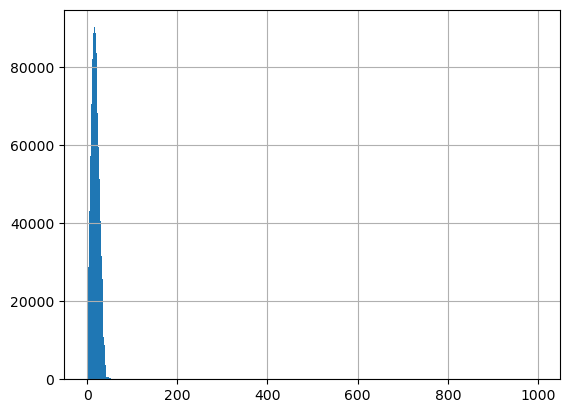

In [161]:
EDA['dti'].hist(bins=500)

<Axes: ylabel='dti'>

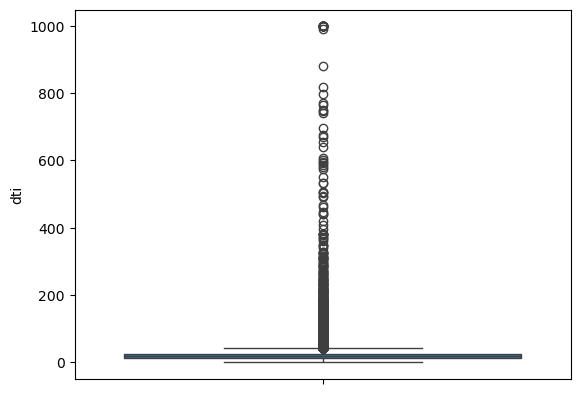

In [162]:
sns.boxplot(data=EDA, y='dti')

In [163]:
EDA['dti'].describe()

count   1034572.000000
mean         18.489699
std          11.240074
min          -1.000000
25%          11.970000
50%          17.800000
75%          24.340000
max         999.000000
Name: dti, dtype: float64

In [164]:
print(f"이상치 하한값: {get_outlier_thresholds(EDA, 'dti')[0]} \n이상치 상한값: {get_outlier_thresholds(EDA, 'dti')[1]}")
print(f"이상치 개수: {count_outliers(EDA, 'dti')}개")

이상치 하한값: -6.584999999999999 
이상치 상한값: 42.894999999999996
이상치 개수: 4258개


In [165]:
EDA.loc[EDA['dti']>100, 'dti'] = 100
EDA['dti'].max()

100.0

In [166]:
#상한값 이상이면 차지오프 비율이 높아지긴함
EDA[EDA['dti']>41][target].value_counts()

loan_status
Fully Paid     3510
Charged Off    1516
Name: count, dtype: int64

In [167]:
EDA[EDA['dti']>41][target]

425515      Fully Paid
630663     Charged Off
502256     Charged Off
545974      Fully Paid
621207      Fully Paid
              ...     
388922     Charged Off
508356     Charged Off
1263890    Charged Off
656195      Fully Paid
1309000     Fully Paid
Name: loan_status, Length: 5026, dtype: object

In [168]:
EDA['binary_loan_status'] = EDA[target]

EDA.loc[EDA['binary_loan_status'] == 'Charged Off', 'binary_loan_status'] = 1
EDA.loc[EDA['binary_loan_status'] == 'Fully Paid', 'binary_loan_status'] = 0
EDA['binary_loan_status'] = EDA['binary_loan_status'].astype('int8')

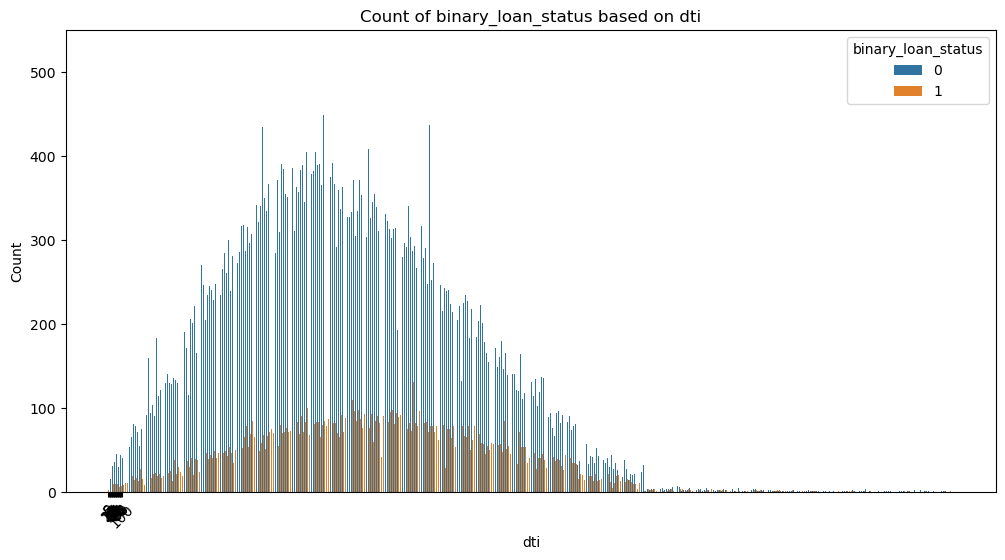

In [180]:
plt.figure(figsize=(12, 6))
sns.countplot(data=EDA, x='dti', hue='binary_loan_status')
plt.title('Count of binary_loan_status based on dti')
plt.xlabel('dti')
plt.ylabel('Count')
plt.ylim(0,550)
# Set specific x-axis ticks
xs = list(range(0, 101))
xlabels = list(range(0, 101))
plt.xticks(ticks=xs, labels=xlabels, rotation=45)
plt.locator_params(axis='x', nbins=len(xlabels)/5)


plt.show()

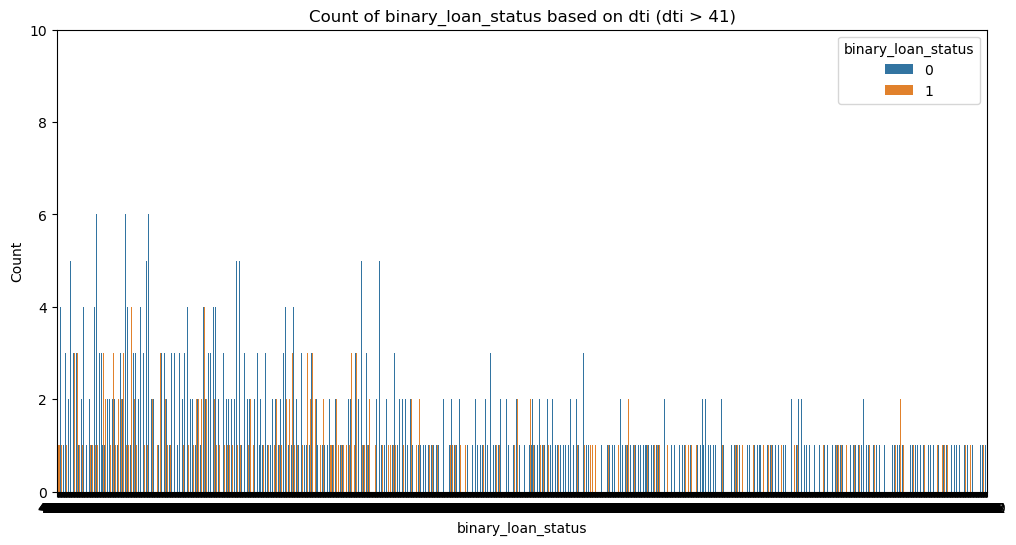

In [178]:
# 41이상 카운트 플롯
filtered_data = EDA[EDA['dti'] > 41]

# Bar plot
plt.figure(figsize=(12, 6))
sns.countplot(data=filtered_data, x='dti', hue='binary_loan_status')
plt.title('Count of binary_loan_status based on dti (dti > 41)')
plt.xlabel('binary_loan_status')
plt.ylabel('Count')
plt.ylim((0,10))


plt.show()

In [172]:
#하한값에 해당하는 이상치는 없음 
#42% 넘어가는 수 이상치 

#### 전처리 아이디어 
- 결측치(이상치) 삭제
- 100이상 넘어가는 것 100으로 맥스 조절
- 구간화 8%씩

In [ ]:
1. mode(최빈값)으로 결측 대체
2. KnnInmputer 
3. IterativeImputer

### **numeric features 이상치 처리**

In [214]:
print_uv(num_feature, 16)

fico_range_high NU: 38
!!!TOO MANY!!!
 [714. 704. 669. 664.]
----------------------------------------------------------------------
fico_range_low NU: 38
!!!TOO MANY!!!
 [710. 700. 665. 660.]
----------------------------------------------------------------------
dti NU: 6318
!!!TOO MANY!!!
 [16.93 35.33 18.11 18.1 ]
----------------------------------------------------------------------
inq_last_6mths NU: 9
[0. 1. 2. 3. 4. 5. 6. 8. 7.] 

----------------------------------------------------------------------
annual_inc NU: 53638
!!!TOO MANY!!!
 [ 56364.  50000. 116640. 107000.]
----------------------------------------------------------------------
loan_amnt NU: 1542
!!!TOO MANY!!!
 [20300. 13600.  8000. 24000.]
----------------------------------------------------------------------
revol_util NU: 1001
!!!TOO MANY!!!
 [39.8 30.  84.3 92.2]
----------------------------------------------------------------------
il_util NU: 1001
!!!TOO MANY!!!
 [ 57.  100.   97.9  29. ]
----------------------

In [160]:
EDA[num_feature].describe()

,fico_range_high,fico_range_low,dti,inq_last_6mths,total_bal_il,bc_open_to_buy,open_rv_24m,open_il_24m,acc_open_past_24mths,open_rv_12m,open_il_12m,num_tl_op_past_12m,open_act_il,num_actv_rev_tl
count,1034888.000000,1034888.000000,1034572.000000,1034888.000000,1034888.000000,1023848.000000,1034888.000000,1034888.000000,1034888.000000,1034888.000000,1034888.000000,1034888.000000,509518.000000,1034888.000000
mean,699.398506,695.398357,18.489699,0.645308,33502.309992,10208.163521,2.373146,1.957710,4.706180,1.020629,0.890281,2.179998,2.388958,5.643761
std,31.469869,31.469159,11.240074,0.930781,40747.047045,15352.574403,2.191488,1.606753,3.196531,1.273302,0.964468,1.846955,2.936797,3.305514
min,664.000000,660.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,674.000000,670.000000,11.970000,0.000000,8436.000000,1474.000000,1.000000,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000,3.000000
50%,694.000000,690.000000,17.800000,0.000000,22323.000000,4722.000000,2.000000,2.000000,4.000000,1.000000,1.000000,2.000000,2.000000,5.000000
75%,714.000000,710.000000,24.340000,1.000000,43698.250000,12421.000000,3.000000,3.000000,6.000000,2.000000,1.000000,3.000000,3.000000,7.000000
max,850.000000,845.000000,999.000000,8.000000,1711009.000000,559912.000000,53.000000,51.000000,64.000000,28.000000,25.000000,32.000000,53.000000,63.000000


C:\Users\medici\AppData\Local\Temp\ipykernel_5504\2781873146.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  EDA[num_feature[3:]].hist(ax=ax)


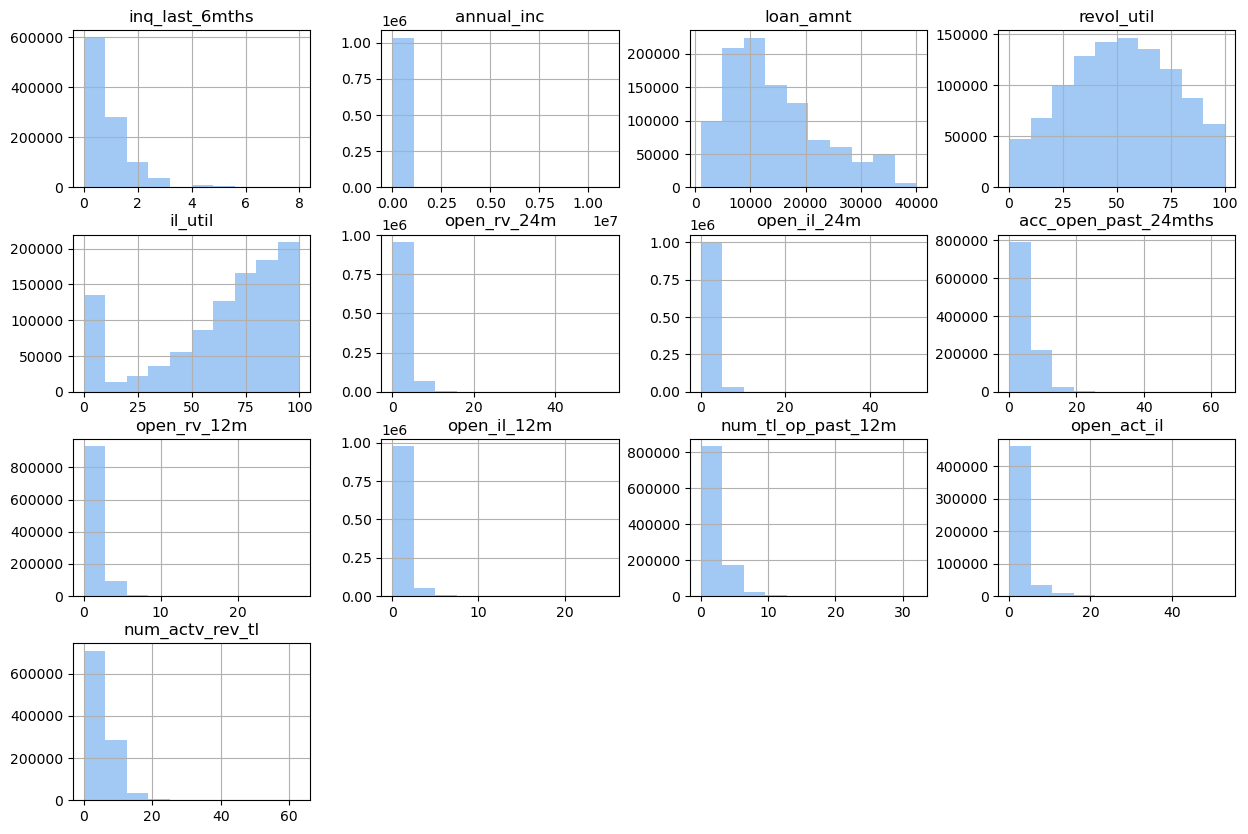

In [217]:
# revol_util
fig = plt.figure(figsize=(15,10))
ax = fig.subplots()
EDA[num_feature[3:]].hist(ax=ax)
plt.show()

In [73]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
EDA['annual_inc'].describe()

count    1089701.00000
mean       76276.12359
std        70171.96580
min            0.00000
25%        45864.00000
50%        65000.00000
75%        90000.00000
max     10999200.00000
Name: annual_inc, dtype: float64

In [92]:
EDA[['annual_inc','grade']][EDA['annual_inc']<10000]

,annual_inc,grade
425515,1200.00000,C
422126,9000.00000,D
887865,8760.00000,D
878950,9783.00000,C
377099,8400.00000,D
...,...,...
393815,2100.00000,B
539700,7500.00000,D
915820,0.00000,E
388922,500.00000,E


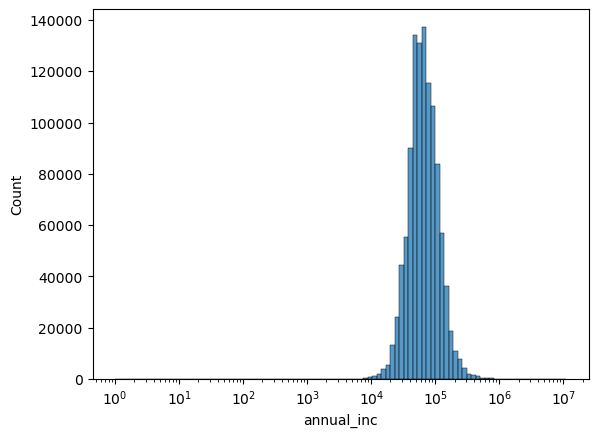

In [76]:
sns.histplot(data=EDA, x='annual_inc', log_scale=True, bins=100)
plt.show()

In [ ]:
EDA['annual_inc']

In [ ]:
EDA

array([[<Axes: title={'center': 'loan_amnt'}>]], dtype=object)

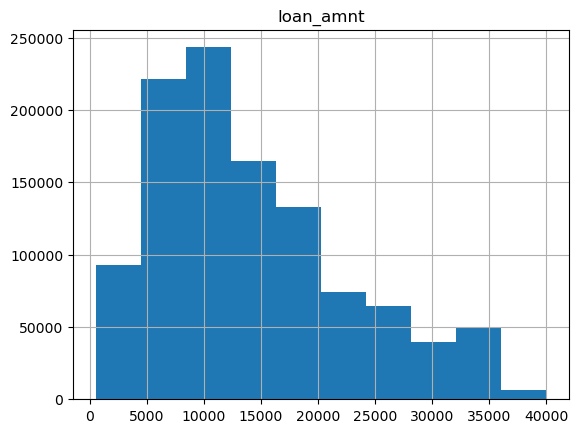

In [152]:
EDA[['loan_amnt']].hist()

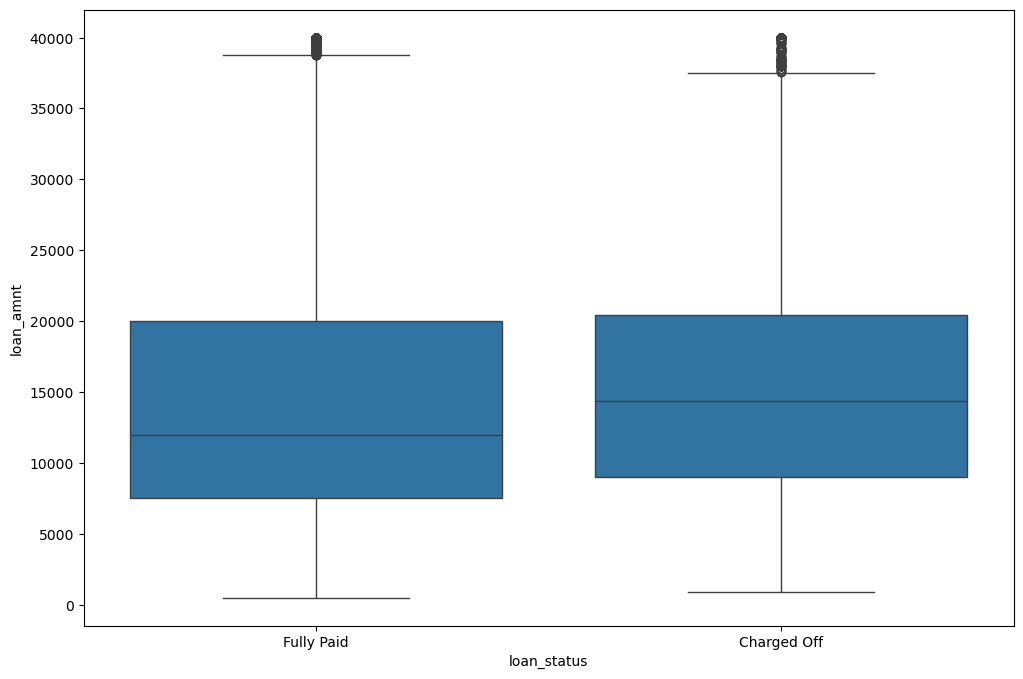

In [155]:
fig = plt.figure(figsize=(12,8))
ax = fig.subplots()

sns.boxplot(data=EDA, y='loan_amnt', x='loan_status', ax=ax)
plt.show()

In [161]:
class Replace_Thresholds(BaseEstimator, TransformerMixin):
    def __init__(self, feature):
        self.feature = feature

    def fit(self, X, y=None):
        Q1 = X[self.feature].quantile(0.25)
        Q3 = X[self.feature].quantile(0.75)
        IQR_range = Q3-Q1
        self.up_fence = Q3 + 1.5 * IQR_range
        self.low_fence = Q1 - 1.5 * IQR_range
        return self

    def transform(self, X):
        X[self.feature] = np.where(X[self.feature] > self.up_fence , self.up_fence, X[self.feature])
        X[self.feature] = np.where(X[self.feature] < self.low_fence , self.low_fence, X[self.feature])
        return X

In [162]:
re = Replace_Thresholds(feature='annual_inc')
df = re.fit_transform(EDA_pipe)

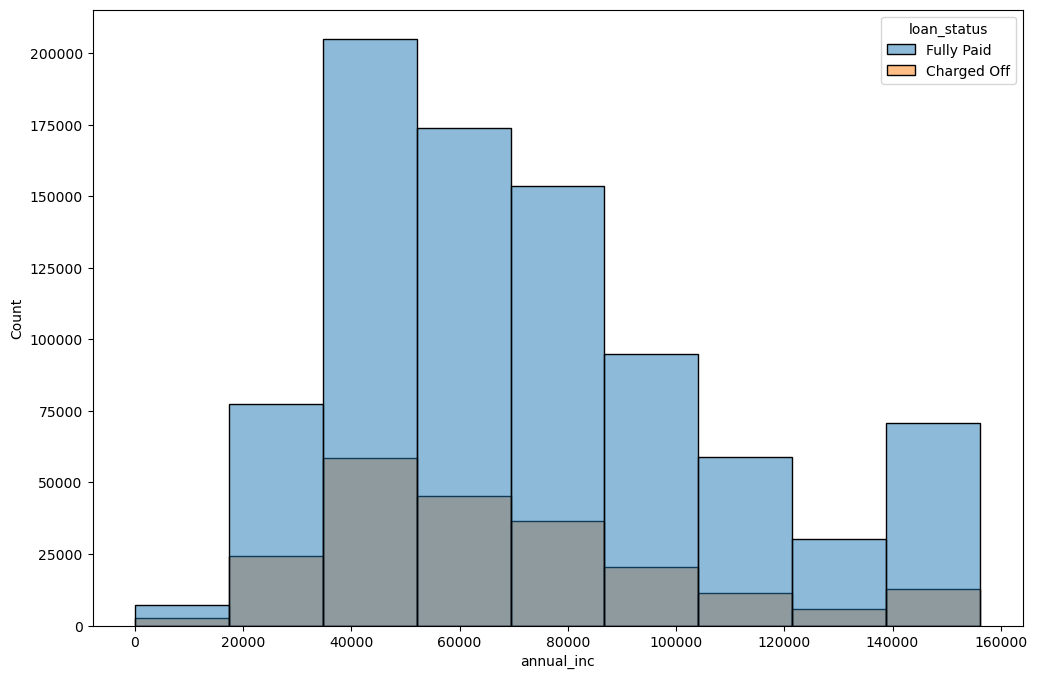

In [170]:
fig = plt.figure(figsize=(12,8))
ax = fig.subplots()

sns.histplot(data=df, x='annual_inc', hue='loan_status', ax=ax, bins=9)
plt.show()

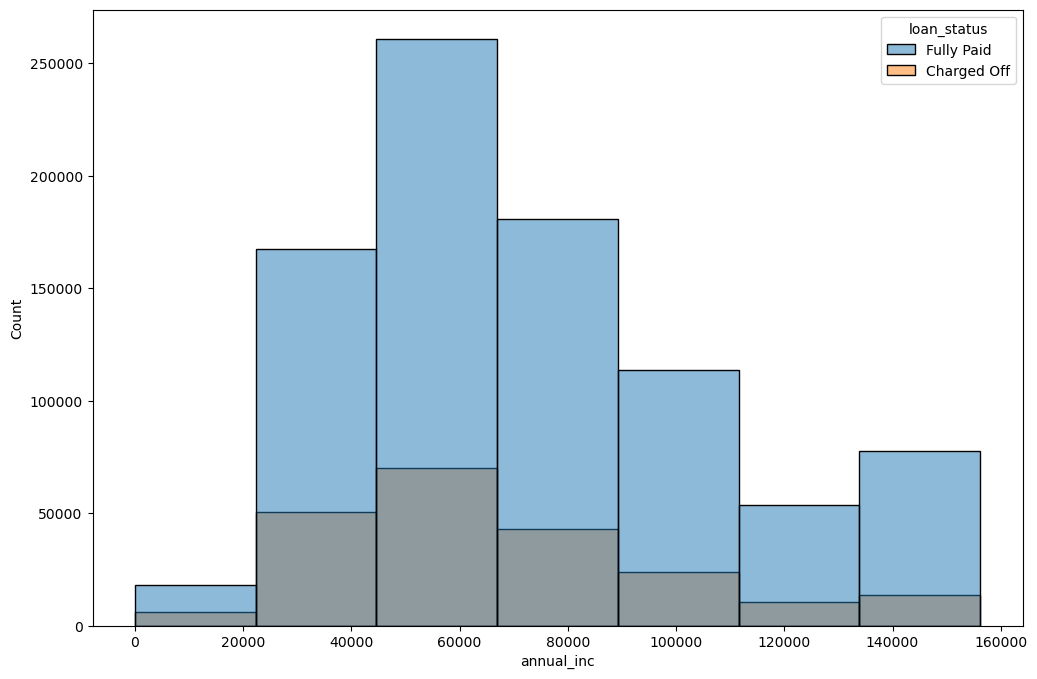

In [182]:
fig = plt.figure(figsize=(12,8))
ax = fig.subplots()

sns.histplot(data=df, x='annual_inc', hue='loan_status', ax=ax, bins=7)
plt.show()

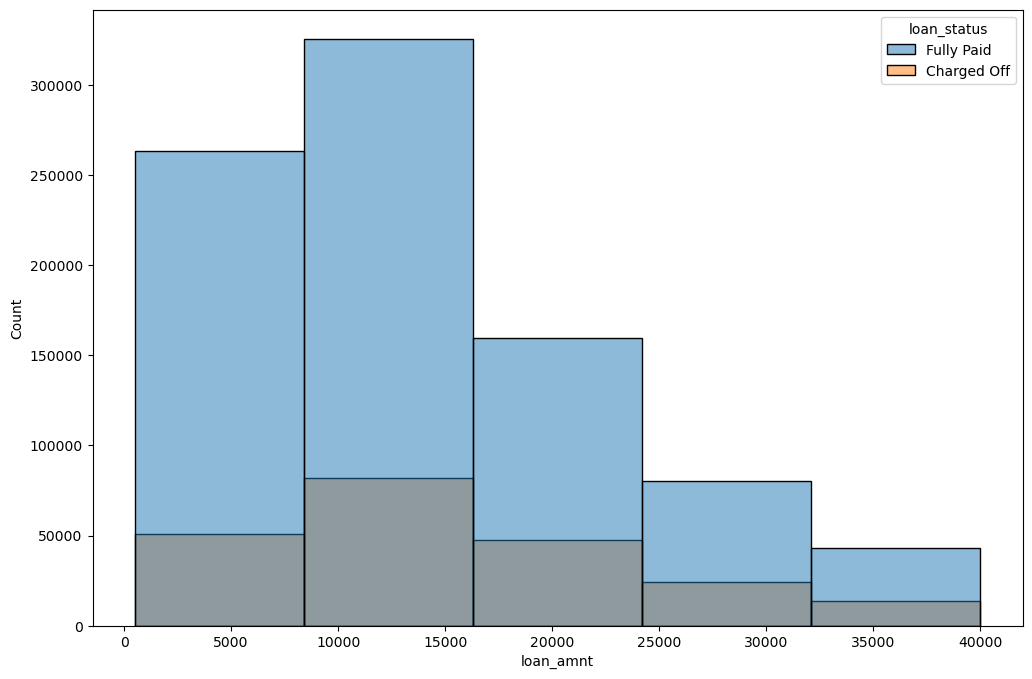

In [190]:
fig = plt.figure(figsize=(12,8))
ax = fig.subplots()

sns.histplot(data=df, x='loan_amnt', hue='loan_status', ax=ax, bins=5)
plt.show()

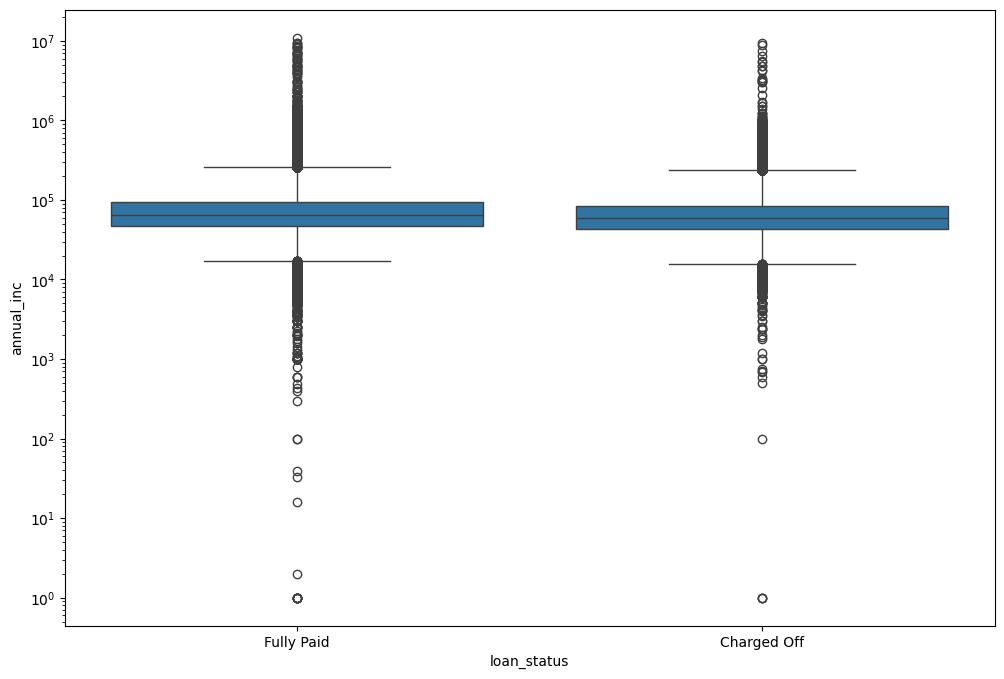

In [149]:
fig = plt.figure(figsize=(12,8))
ax = fig.subplots()

sns.boxplot(data=EDA, y='annual_inc', x='loan_status', ax=ax, log_scale=True)
plt.show()

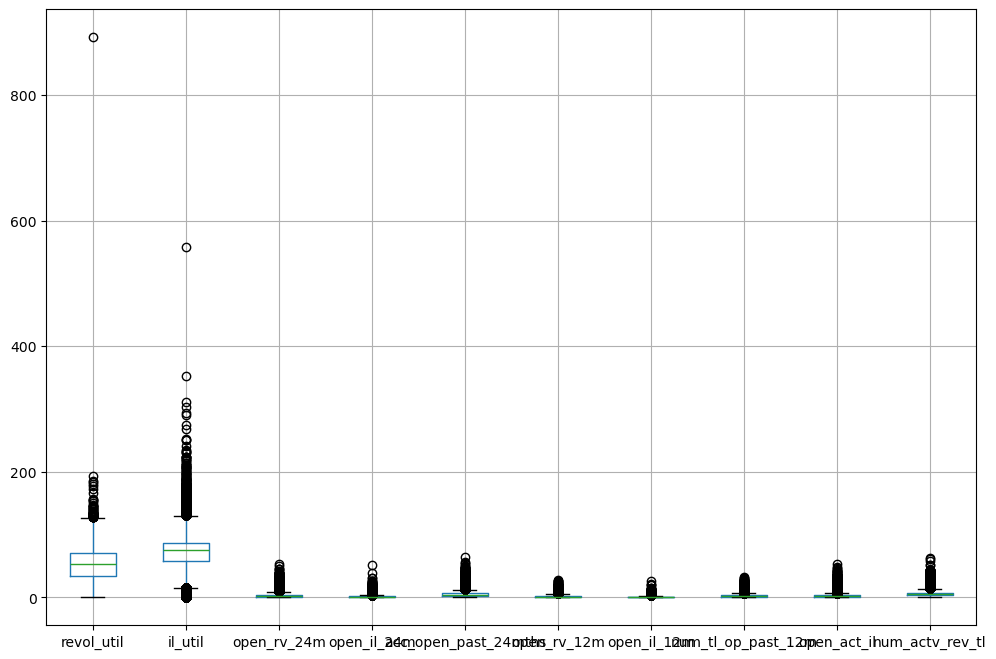

In [66]:

fig = plt.figure(figsize=(12,8))
ax = fig.subplots()
EDA[num_feature[6:]].boxplot(ax=ax)
plt.show()

In [148]:
EDA[['annual_inc','loan_status']].groupby('loan_status').size()

loan_status
Charged Off    217533
Fully Paid     872168
dtype: int64

In [145]:
EDA[['annual_inc','loan_status']][EDA['annual_inc']>158500].groupby('loan_status').size()

loan_status
Charged Off     7730
Fully Paid     44909
dtype: int64

In [224]:
for i in num_feature[:]:
    print(i)
    print(f"이상치 하한값: {get_outlier_thresholds(EDA, i)[0]} \n이상치 상한값: {get_outlier_thresholds(EDA, i)[1]}")
    print(f"이상치 개수: {count_outliers(EDA, i)}개")
    print('---'*20)

fico_range_high
이상치 하한값: 614.0 
이상치 상한값: 774.0
이상치 개수: 34094개
------------------------------------------------------------
fico_range_low
이상치 하한값: 610.0 
이상치 상한값: 770.0
이상치 개수: 34094개
------------------------------------------------------------
dti
이상치 하한값: -6.584999999999999 
이상치 상한값: 42.894999999999996
이상치 개수: 4258개
------------------------------------------------------------
inq_last_6mths
이상치 하한값: -1.5 
이상치 상한값: 2.5
이상치 개수: 53091개
------------------------------------------------------------
annual_inc
이상치 하한값: -21500.0 
이상치 상한값: 158500.0
이상치 개수: 50752개
------------------------------------------------------------
loan_amnt
이상치 하한값: -10000.0 
이상치 상한값: 38000.0
이상치 개수: 5795개
------------------------------------------------------------
revol_util
이상치 하한값: -22.0 
이상치 상한값: 126.0
이상치 개수: 0개
------------------------------------------------------------
il_util
이상치 하한값: -7.749999999999993 
이상치 상한값: 143.85
이상치 개수: 0개
------------------------------------------------------------
open_rv_24m
이상치 

#### 전처리 
- ['open_rv_24m', 'open_il_24m', 'open_rv_12m', 'open_il_12m', 'open_act_il', 'num_actv_rev_tl'] : 로그 스케일링    ~~구간화, 이상치 상한값 이후 값 한개의 그룹으로~~
- 'inq_last_6mths' : Ordinal Encoding
- ['annual_inc','loan_amnt'] : 로그 스케일링
- 'revol_util': 100limit, StadardScaler
- 'il_util' : 100limit, minmax
- 'fico_range_high' : 구간화 (등급 기준값으로) / Quantile
- 'dti' : 결측치(이상치) most_frequency / 50이상 넘어가는 것 50으로 맥스 조절 / 구간화 10%씩

In [ ]:

num_pre = make_column_transformer(
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=9), ['inq_last_6mths']),
    (logger, ['annual_inc', 'loan_amnt', 'open_rv_24m', 'open_il_24m', 'open_rv_12m', 'open_il_12m', 'open_act_il', 'num_actv_rev_tl']),
    (make_pipeline(FunctionTransformer(max100_limit), StandardScaler()),['revol_util']),
    (make_pipeline(FunctionTransformer(max100_limit), MinMaxScaler()), ['il_util']),
    (make_pipeline(SimpleImputer(strategy='most_frequent'), FunctionTransformer(max50_limit), 
                   KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform', random_state=42)), ['dti']),
    (KBinsDiscretizer(encode='ordinal', strategy='quantile', random_state=42), ['fico_range_high']),    
    remainder='passthrough',
    n_jobs=-1,
    verbose_feature_names_out=False,
)


In [72]:
# 함수 정의

logger = FunctionTransformer(np.log1p, validate=False, check_inverse=False)


def max50_limit(x):
    return np.where(x >= 50, 50, x)

def max100_limit(x):
    return np.where(x >= 100, 100, x)

num_pre = make_column_transformer(
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=9), ['inq_last_6mths']),
    (logger, ['annual_inc', 'loan_amnt', 'open_rv_24m', 'open_il_24m', 'open_rv_12m', 'open_il_12m', 'open_act_il', 'num_actv_rev_tl']),
    (make_pipeline(FunctionTransformer(func=max100_limit), StandardScaler()),['revol_util']),
    (make_pipeline(FunctionTransformer(func=max100_limit), MinMaxScaler()), ['il_util']),
    (make_pipeline(SimpleImputer(strategy='most_frequent'), FunctionTransformer(func=max50_limit), 
                   KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform', random_state=42)), ['dti']),
    (KBinsDiscretizer(encode='ordinal', strategy='quantile', random_state=42), ['fico_range_high']),    
    remainder='passthrough',
    n_jobs=-1,
    verbose_feature_names_out=False,
)



num_pre.fit(EDA_pipe1)

ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('ordinalencoder',
                                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                                unknown_value=9),
                                 ['inq_last_6mths']),
                                ('functiontransformer',
                                 FunctionTransformer(check_inverse=False,
                                                     func=<ufunc 'log1p'>),
                                 ['annual_inc', 'loan_amnt', 'open_rv_24m',
                                  'open_il_24m', 'open_rv_12m', 'open_il_12m',
                                  'open_act_il', 'num_actv_rev_tl']),
                                ('kbinsdiscretizer',
                                 KBinsDiscretizer(encode='ordinal',
                                                  random_state=42),
                                 ['fico_range_high'])],
                  verbose_feature_names_out=False)

In [112]:
num_pre.fit(EDA_pipe1)

ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('ordinalencoder',
                                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                                unknown_value=9),
                                 ['inq_last_6mths']),
                                ('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('functiontransformer',
                                                  FunctionTransformer(check_inverse=False,
                                                                      func=<ufunc 'log1p'>))]),
                                 ['num_actv_...
                                ('pipeline-6',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('max_limit',
                                                  Max_Limit(feature='dti',
                                                            n=50)),
                                                 ('kbinsdiscretizer',
                                                  KBinsDiscretizer(encode='ordinal',
                                                                   random_state=42,
                                                                   strategy='uniform'))]),
                                 ['dti']),
                                ('kbinsdiscretizer',
                                 KBinsDiscretizer(encode='ordinal',
                                                  random_state=42),
                                 ['fico_range_high'])],
                  verbose_feature_names_out=False)

In [245]:
num_pre.fit_transform(EDA)

array([[0.0, 10.463131911491967, 9.392745258631441, ..., nan,
        'Fully Paid', 0],
       [0.0, 10.939603677478631, 9.918425424900335, ..., nan,
        'Fully Paid', 0],
       [1.0, 10.819798284210286, 9.517898598432753, ..., nan,
        'Fully Paid', 0],
       ...,
       [1.0, 11.918397239722838, 9.210440366976517, ..., nan,
        'Fully Paid', 0],
       [0.0, 11.502885230075814, 10.12667110305036, ..., nan,
        'Fully Paid', 0],
       [0.0, 11.813037464800539, 10.463131911491967, ..., nan,
        'Fully Paid', 0]], dtype=object)

#### fico (구간화)

In [184]:
fico = ['fico_range_high', 'fico_range_low']

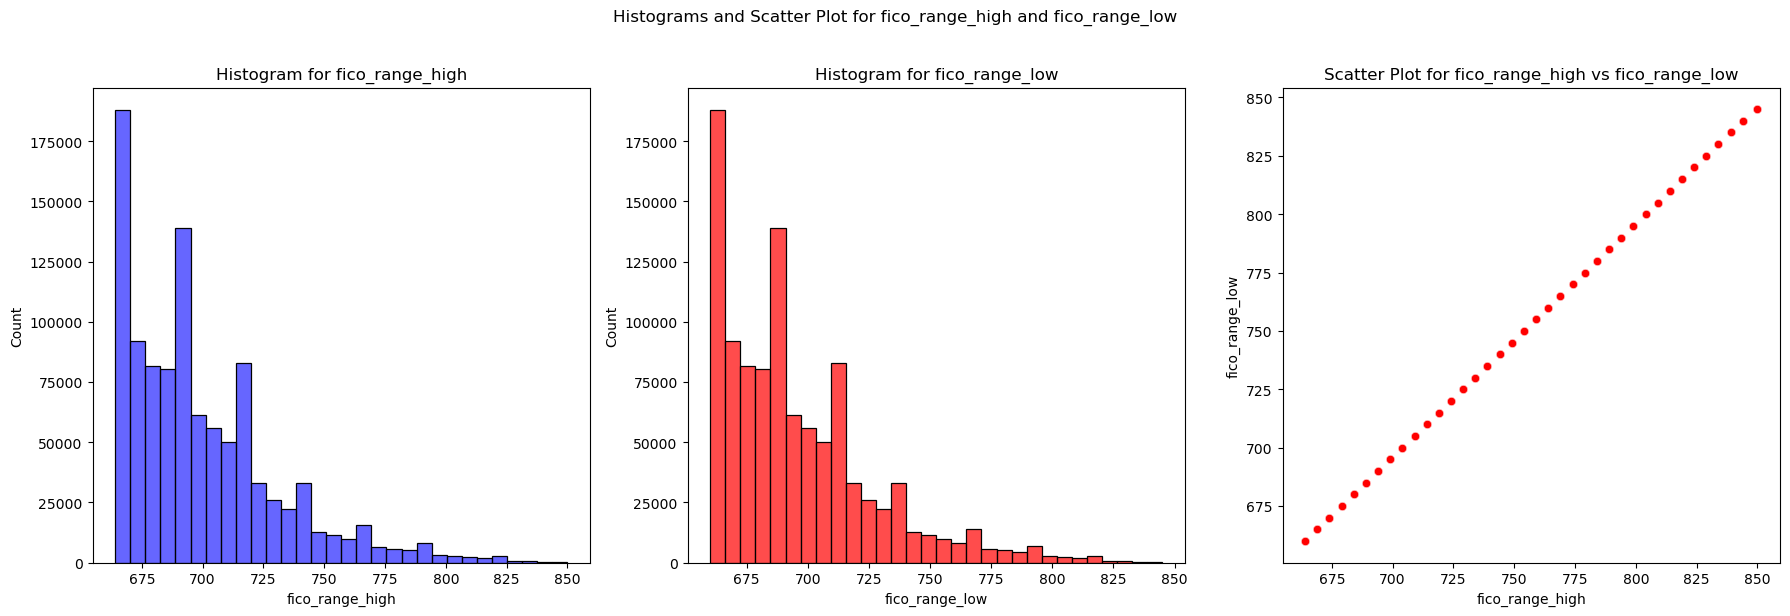

In [185]:
# 히스토그램 그리기
plt.figure(figsize=(18, 6))  # Increased the figure size for better visibility

# 1. high 분포
plt.subplot(1, 3, 1)
sns.histplot(data=EDA, x='fico_range_high', bins=30, color='blue', alpha=0.6)
plt.title('Histogram for fico_range_high')

# 2. low 분포
plt.subplot(1, 3, 2)
sns.histplot(data=EDA, x='fico_range_low', bins=30, color='red', alpha=0.7)
plt.title('Histogram for fico_range_low')

# 3. high-low 스캐터
plt.subplot(1, 3, 3)
sns.scatterplot(data=EDA, x='fico_range_high', y='fico_range_low', color='red', alpha=0.6)
plt.title('Scatter Plot for fico_range_high vs fico_range_low')

plt.suptitle('Histograms and Scatter Plot for fico_range_high and fico_range_low', y=1.02)  # Add a title for the entire figure
plt.tight_layout()
plt.show()

> 두 특성인 'fico_range_high'와 'fico_range_low'의 분포가 거의 동일하며, 두 특성 간의 스캐터 플롯에서 나타나는 선형 관계는 거의 완벽한 1:1 비율을 보인다. 두 특성이 상당히 유사한 정보를 제공하고 있다고 판단됨. **따라서 두 특성 중 하나만 선택하여 사용하는 것으로 결정.**

In [186]:
# 논리적 이상치: 신용점수 범위 300~850 넘어가는 값(이상치) 확인 - 없음
len(EDA[(EDA['fico_range_high'] < 300) | (EDA['fico_range_high'] > 850)])

0

In [187]:
EDA[fico].describe()

,fico_range_high,fico_range_low
count,1034888.000000,1034888.000000
mean,699.398506,695.398357
std,31.469869,31.469159
min,664.000000,660.000000
25%,674.000000,670.000000
50%,694.000000,690.000000
75%,714.000000,710.000000
max,850.000000,845.000000


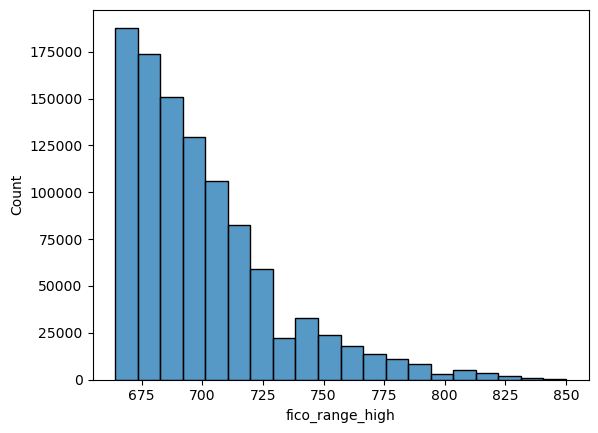

In [188]:
sns.histplot(data=EDA, x='fico_range_high', bins=20)
plt.show()

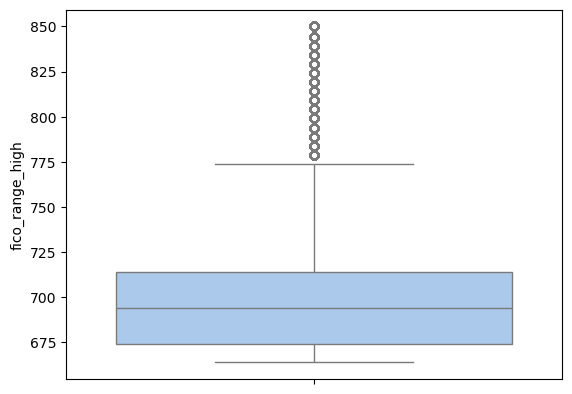

In [189]:
sns.set_palette("pastel")
sns.boxplot(data=EDA, y='fico_range_high');

> 300~850 까지 범위이자만 해당 특성의 대부분의 값이 675와 720 사이에 위치에 있음.
> 하한 이상치는 없고, 상한 이상치만 있음

##### 1번째 구간화 방법.
**미국의 신용평가점수제도 FICO 스코어 등급 구간값 사용(300점~850점구간)**

- very poor : 300 ~ 549
  
- poor : 550 ~ 649
  
- fair : 650 ~ 699
  
- good : 700 ~ 749
  
- excellent : 750 ~ 850


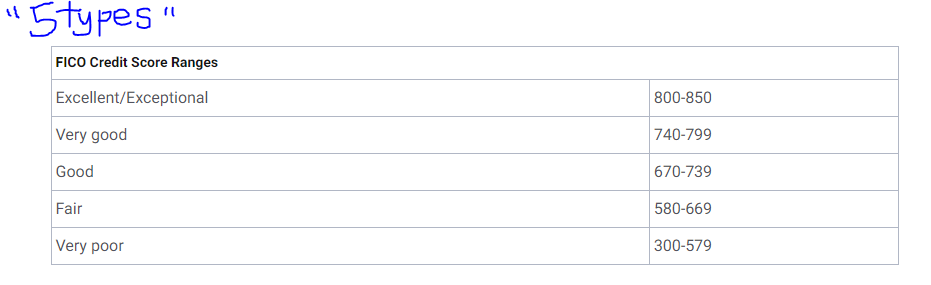


In [190]:
print(f"이상치 하한값: {get_outlier_thresholds(EDA, 'fico_range_high')[0]} \n이상치 상한값: {get_outlier_thresholds(EDA, 'fico_range_high')[1]}")
print(f"이상치 개수: {count_outliers(EDA, 'fico_range_high')}개")


이상치 하한값: 614.0 
이상치 상한값: 774.0
이상치 개수: 34094개


In [191]:
print(f"Fair Level: {len(EDA[(EDA['fico_range_high'] >= 580) & (EDA['fico_range_high'] <= 669)])}개, 비율: {(len(EDA[(EDA['fico_range_high'] >= 580) & (EDA['fico_range_high'] <= 669)]) / EDA.shape[0] *100):.2f}%")
print(f"Good Level: {len(EDA[(EDA['fico_range_high'] >= 670) & (EDA['fico_range_high'] <= 739)])}개, 비율: {(len(EDA[(EDA['fico_range_high'] >= 670) & (EDA['fico_range_high'] <= 739)]) / EDA.shape[0] *100):.2f}%")
print(f"Very Good Level: {len(EDA[(EDA['fico_range_high'] >= 740) & (EDA['fico_range_high'] <= 799)])}개, 비율: {(len(EDA[(EDA['fico_range_high'] >= 740) & (EDA['fico_range_high'] <= 799)]) / EDA.shape[0] *100):.2f}%")
print(f"Excellent Level: {len(EDA[(EDA['fico_range_high'] >= 800) & (EDA['fico_range_high'] <= 850)])}개, 비율: {(len(EDA[(EDA['fico_range_high'] >= 800) & (EDA['fico_range_high'] <= 850)]) / EDA.shape[0] *100):.2f}%")

Fair Level: 187884개, 비율: 18.16%
Good Level: 741740개, 비율: 71.67%
Very Good Level: 93523개, 비율: 9.04%
Excellent Level: 11741개, 비율: 1.13%


> fico : P2P 대출 승인자는 전부 Fair등급 이상 
>> 제공된 기준 등급 컷으로 구간화 할 경우 good level에 값이 거의 분포함 : 불균형이 심함

In [ ]:
#사분위수 구간화

### **category features**

In [150]:
print_uv(cat_feature, 16)

emp_length NU: 11
['6 years' '10+ years' nan '3 years' '2 years' '< 1 year' '4 years'
 '8 years' '7 years' '9 years' '5 years' '1 year'] 

----------------------------------------------------------------------
addr_state NU: 51
!!!TOO MANY!!!
 ['WA' 'NV' 'TX' 'MD']
----------------------------------------------------------------------
term NU: 2
[' 36 months' ' 60 months'] 

----------------------------------------------------------------------
verification_status NU: 3
['Not Verified' 'Verified' 'Source Verified'] 

----------------------------------------------------------------------
grade NU: 7
['C' 'D' 'A' 'B' 'E' 'F' 'G'] 

----------------------------------------------------------------------
sub_grade NU: 35
!!!TOO MANY!!!
 ['C4' 'D3' 'A5' 'B2']
----------------------------------------------------------------------
purpose NU: 14
['credit_card' 'debt_consolidation' 'car' 'home_improvement'
 'major_purchase' 'other' 'medical' 'house' 'small_business' 'vacation'
 'moving' 'renewa

In [ ]:
#Frequency Encoding

#대출이 승인이 많은 곳일수록 부촌일 지역인 확률이 높아짐
#(실제로 경제 생산액(GDP) 높은 주의 순서와 비슷한 순서를 보임)
#실제: CA, TX, NY, FL, IL, PA, OH, GA, WT, NJ
#데이터 : CA, TX, NY, FL, IL, NJ, PA, OH, GA
EDA['addr_state'].value_counts()

OnehotEncoding
- verification
- purpose
- term 

OrdinalEncoding 
- grade
- subgrade
- emp_length(결측처리: simpleImputer: mode)

Frequency Encoding
- addr_state

In [151]:
# 카테고리 컬럼 파이프라인

In [152]:
emp_order = [['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', '6 years','7 years',
 '8 years', '9 years', '10+ years']]

grade_order = [['G','F','E','D','C','B','A']]
sub_order = [np.sort(EDA['sub_grade'].unique())[::-1].tolist()]

In [157]:
#!pip install category_encoders

In [158]:
class GroupbyImputer(BaseEstimator, TransformerMixin):
    
    ''' 
    그룹별 통계값으로 결측치를 대체하는 클래스입니다.
    group : 결측치 대체의 그룹으로 사용할 컬럼
    nan_feature : 결측치가 있는 컬럼
    strategy : 결측치 대체 전략으로, 'mean','median','mode'를 매개변수로 받을 수 있습니다.
    
    '''
    
    def __init__(self, group, nan_feature, strategy):
        self.group = group
        self.nan_feature = nan_feature
        self.strategy = strategy if strategy != 'mode' else lambda x: x.mode().iloc[0]       
        

    def fit(self, X, y=None):
        #각 그룹별 self.strategy로 바꾼 X 데이터프레임 저장
        self.groupbydf = X.groupby(self.group)[self.nan_feature].transform(self.strategy)
        return self

    
    def transform(self, X):
        #결측있는 인덱스와 self.groupbydf 인덱스의 값으로 결측치 채움  
        X[self.nan_feature].fillna(self.groupbydf, inplace=True)
        return X

In [154]:
import category_encoders as ce
from sklearn import set_config
set_config(transform_output="default")

cat_pre = make_column_transformer(
    (OneHotEncoder(), ['verification_status', 'purpose', 'term']),
    (make_pipeline(OrdinalEncoder(categories=sub_order)), ['sub_grade']),
    (make_pipeline(OrdinalEncoder(categories=grade_order)), ['grade']),
    (ce.CountEncoder(), ['addr_state']),
    (make_pipeline(SimpleImputer(strategy='most_frequent'), OrdinalEncoder(categories=emp_order)), ['emp_length']),
    remainder='passthrough',
    verbose_feature_names_out=False
)

In [155]:
cat_pre.fit(EDA_pipe1)

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder', OneHotEncoder(),
                                 ['verification_status', 'purpose', 'term']),
                                ('pipeline-1',
                                 Pipeline(steps=[('ordinalencoder',
                                                  OrdinalEncoder(categories=[['G5',
                                                                              'G4',
                                                                              'G3',
                                                                              'G2',
                                                                              'G1',
                                                                              'F5',
                                                                              'F4',
                                                                              'F3',
                                                                              'F2',
                                                                              'F1',
                                                                              'E5',
                                                                              'E4',
                                                                              'E3',
                                                                              'E2',
                                                                              'E1',
                                                                              'D5',
                                                                              'D4',
                                                                              'D3',
                                                                              'D2',
                                                                              'D1',
                                                                              'C5',
                                                                              'C4',
                                                                              'C3',
                                                                              'C2',
                                                                              'C1',
                                                                              'B5',
                                                                              'B4',
                                                                              'B3',
                                                                              'B2...
                                 CountEncoder(combine_min_nan_groups=True),
                                 ['addr_state']),
                                ('pipeline-3',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['< '
                                                                              '1 '
                                                                              'year',
                                                                              '1 '
                                                                              'year',
                                                                              '2 '
                                                                              'years',
                                                                              '3 '
                                                                              'years',
                                                                              '4 '
                

In [101]:
cat_pre.fit_transform(EDA_pipe1)

array([[ 1.,  0.,  0., ..., 24., 24., nan],
       [ 1.,  0.,  0., ..., 13., 13., 31.],
       [ 0.,  0.,  1., ...,  2.,  4.,  2.],
       ...,
       [ 1.,  0.,  0., ...,  3.,  9.,  3.],
       [ 0.,  1.,  0., ..., 20., 22., nan],
       [ 0.,  1.,  0., ...,  7.,  7., nan]])

## **전처리 파이프라인**

In [ ]:
EDA_pipe = pd.concat((X_train, y_train), axis=1)

In [5]:
num_feature = ['fico_range_high',  'dti', 'inq_last_6mths', 'annual_inc', 'loan_amnt', 'revol_util', 'il_util', 'open_rv_24m', 'open_il_24m', 'open_rv_12m', 'open_il_12m',  'num_actv_rev_tl']
cat_feature = ['emp_length', 'addr_state', 'term', 'verification_status', 'grade', 'sub_grade', 'purpose']

In [8]:
emp_order = [['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', '6 years','7 years',
 '8 years', '9 years', '10+ years']]

grade_order = [['G','F','E','D','C','B','A']]
sub_order = [np.sort(EDA['sub_grade'].unique())[::-1].tolist()]


import category_encoders as ce
from sklearn import set_config
set_config(transform_output="pandas")


cat_pre = make_column_transformer(
    (OneHotEncoder(sparse_output=False), ['verification_status', 'purpose', 'term']),
    (make_pipeline(OrdinalEncoder(categories=sub_order)), ['sub_grade']),
    (make_pipeline(OrdinalEncoder(categories=grade_order)), ['grade']),
    (ce.CountEncoder(), ['addr_state']),
    (make_pipeline(SimpleImputer(strategy='most_frequent'), OrdinalEncoder(categories=emp_order)), ['emp_length']),
    remainder='passthrough',
    verbose_feature_names_out=False
)

In [10]:
cat_pre

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder',
                                 OneHotEncoder(sparse_output=False),
                                 ['verification_status', 'purpose', 'term']),
                                ('pipeline-1',
                                 Pipeline(steps=[('ordinalencoder',
                                                  OrdinalEncoder(categories=[['G5',
                                                                              'G4',
                                                                              'G3',
                                                                              'G2',
                                                                              'G1',
                                                                              'F5',
                                                                              'F4',
                                                                              'F3',
                                                                              'F2',
                                                                              'F1',
                                                                              'E5',
                                                                              'E4',
                                                                              'E3',
                                                                              'E2',
                                                                              'E1',
                                                                              'D5',
                                                                              'D4',
                                                                              'D3',
                                                                              'D2',
                                                                              'D1',
                                                                              'C5',
                                                                              'C4',
                                                                              'C3',
                                                                              'C2',
                                                                              'C1'...
                                 CountEncoder(combine_min_nan_groups=True),
                                 ['addr_state']),
                                ('pipeline-3',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['< '
                                                                              '1 '
                                                                              'year',
                                                                              '1 '
                                                                              'year',
                                                                              '2 '
                                                                              'years',
                                                                              '3 '
                                                                              'years',
                                                                              '4 '
                                                                              'years',
                                                                              '5 '
                                                                              'years',
                                          

In [9]:
df1 =cat_pre.fit_transform(EDA_pipe)
df1

,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,...,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,loan_status
1126992,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Fully Paid
530674,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Fully Paid
465057,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Fully Paid
148918,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Charged Off
31145,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Fully Paid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1187260,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Fully Paid
673511,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Charged Off
509553,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Fully Paid
107784,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Fully Paid


In [132]:
df1[pre_cat_feature]

,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,...,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,term_ 36 months,term_ 60 months,sub_grade,grade,addr_state,emp_length
1126992,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,24.0,4.0,9130,6.0
530674,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,21.0,4.0,23683,10.0
465057,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,17.0,3.0,16358,10.0
148918,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,30.0,6.0,89267,3.0
31145,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,28.0,5.0,25328,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1187260,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,30.0,6.0,77351,2.0
673511,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,12.0,2.0,88875,0.0
509553,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,24.0,4.0,16358,3.0
107784,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,33.0,6.0,89267,10.0


In [34]:
#아이디어 1단계
class NZero_Imputer(BaseEstimator, TransformerMixin):
    def __init__(self, n, nan_feature, cond):
        self.nan_feature = nan_feature
        self.cond = cond
        self.n = n

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X[self.nan_feature] = np.where(X[self.cond] > self.n, 0, X[self.nan_feature])
        return X

#아이디어 2단계
class CalImputer(BaseEstimator, TransformerMixin):
    
    def __init__(self, nan_feature, total, another):
        self.nan_feature = nan_feature
        self.total = total
        self.another = another

    def fit(self, X, y=None):
        self.value = X[self.total] - X[self.another] 
        return self

    def transform(self, X):
        X[self.total] = X[self.total].fillna(X[self.total].median())
        X[self.nan_feature] = X[self.nan_feature].fillna(self.value)
        X[self.nan_feature] = np.where(X[self.total] == 0, 0, X[self.nan_feature])
        return X

#아이디어 3단계
class Devide_Imputer(BaseEstimator, TransformerMixin):
    
    def __init__(self, nan_feature, total, another):
        self.nan_feature = nan_feature
        self.total = total
        self.another = another

    def fit(self, X, y=None):
        self.value = (X[self.total] // 2)
        return self

    def transform(self, X):
        X[self.nan_feature] = X[self.nan_feature].fillna(self.value)
        X[self.another] = X[self.another].fillna(self.value)
        return X

In [54]:
mths.fit_transform(EDA_pipe)[['open_il_24m', 'open_il_12m']].isna().sum()

open_il_24m    0
open_il_12m    0
dtype: int64

In [35]:
mths_pre = Pipeline(steps=[
    
   
    ('il24_zero', NZero_Imputer(n=24, nan_feature='open_il_24m', cond='mths_since_rcnt_il')),
    
    ('rv24_impute1', CalImputer(nan_feature='open_rv_24m', total='acc_open_past_24mths', another='open_il_24m')),
    ('il24_impute1', CalImputer(nan_feature='open_il_24m', total='acc_open_past_24mths', another='open_rv_24m')),
    ('rv_il_24_impute2', Devide_Imputer(nan_feature='open_rv_24m', total='acc_open_past_24mths', another='open_il_24m')),
    

    ('rv12_zero', NZero_Imputer(n=12, nan_feature='open_rv_12m', cond='mo_sin_rcnt_rev_tl_op')),
    ('il12_zero', NZero_Imputer(n=12, nan_feature='open_il_12m', cond='mths_since_rcnt_il')),
    ('rv12_impute1', CalImputer(nan_feature='open_rv_12m', total='num_tl_op_past_12m', another='open_il_12m')),
    ('il12_impute1', CalImputer(nan_feature='open_il_12m', total='num_tl_op_past_12m', another='open_rv_12m')),
    ('rv_il_12_impute2', Devide_Imputer(nan_feature='open_rv_12m', total='num_tl_op_past_12m', another='open_il_12m'))
])

In [36]:
pre_2 = Pipeline(steps=[
    ('cat_1', cat_pre),
    ('num_1', mths_pre)])

In [38]:
df2 =pre_2.fit_transform(EDA_pipe)

In [40]:
df2[num_feature].isna().sum()

fico_range_high         0
dti                   316
inq_last_6mths          0
annual_inc              0
loan_amnt               0
revol_util            698
il_util            712908
open_rv_24m             0
open_il_24m             0
open_rv_12m             0
open_il_12m             0
num_actv_rev_tl     54676
dtype: int64

In [58]:
df2 = mths_pre.fit_transform(df1)
df2

,num_tl_op_past_12m,acc_open_past_24mths,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,...,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,loan_status
1126992,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Fully Paid
530674,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Fully Paid
465057,4.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Fully Paid
148918,7.0,9.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Charged Off
31145,2.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Fully Paid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1187260,2.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Fully Paid
673511,4.0,6.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Charged Off
509553,6.0,12.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Fully Paid
107784,0.0,6.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Fully Paid


In [90]:
df[num_feature]

,fico_range_high,dti,inq_last_6mths,annual_inc,loan_amnt,revol_util,il_util,open_rv_24m,open_il_24m,open_rv_12m,open_il_12m,num_actv_rev_tl
1126992,679.0,20.06,0.0,35000.0,12000.0,87.3,0.0,NaN,NaN,NaN,NaN,6.0
530674,714.0,16.93,0.0,56364.0,20300.0,39.8,57.0,1.0,0.0,0.0,0.0,8.0
465057,679.0,35.33,1.0,50000.0,13600.0,30.0,100.0,1.0,3.0,1.0,3.0,1.0
148918,704.0,18.11,0.0,116640.0,8000.0,30.0,97.9,NaN,NaN,NaN,NaN,9.0
31145,669.0,18.10,0.0,107000.0,24000.0,84.3,29.0,NaN,NaN,NaN,NaN,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
109985,714.0,13.06,0.0,60000.0,24000.0,32.1,0.0,NaN,NaN,NaN,NaN,11.0
673511,694.0,20.98,1.0,110000.0,25000.0,60.0,80.5,NaN,NaN,NaN,NaN,10.0
509553,704.0,27.03,1.0,150000.0,10000.0,39.6,79.0,4.0,8.0,2.0,4.0,8.0
107784,739.0,28.73,0.0,99000.0,25000.0,41.8,59.1,NaN,NaN,NaN,NaN,8.0


In [41]:
from sklearn import set_config
set_config(transform_output="pandas")


In [79]:
preutil[['il_util','revol_util']].max()

il_util       100.0
revol_util    100.0
dtype: float64

In [71]:
EDA_pipe['revol_bal']

1126992    18861.0
530674     18723.0
465057      4623.0
148918     11011.0
31145      37090.0
            ...   
1187260     3076.0
673511     16977.0
509553     13273.0
107784     20946.0
162341     37613.0
Name: revol_bal, Length: 1089701, dtype: float64

In [42]:

util_pre = Pipeline(steps=[
    ('total_il_limit_impute', ZeroImputer(nan_feature='total_il_high_credit_limit, cond='total_bal_il')),
    ('bal_il_impute', BalImputer(nan_feature='total_bal_il')),
    ('il_util_impute', UtilCalImputer(nan_feature='il_util', bal='total_bal_il', limit='total_il_high_credit_limit')),
    ('total_rev_limit_impute', ZeroImputer(nan_feature='total_rev_hi_lim', cond='revol_bal')),
    ('rev_util_impute', UtilCalImputer(nan_feature='revol_util', bal="revol_bal", limit="total_rev_hi_lim"))

])   

In [18]:
pre_3 = Pipeline(steps=[
    ('cat_1', cat_pre),
    ('num_1', mths_pre),
    ('num_2', util_pre)])

In [43]:
util_pre.fit_transform(EDA_pipe)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,loan_status
1126992,3359931,NaN,12000.0,12000.0,12000.0,36 months,14.33,412.06,C,C1,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Fully Paid
530674,110061292,NaN,20300.0,20300.0,20300.0,60 months,15.05,483.47,C,C4,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Fully Paid
465057,78729404,NaN,13600.0,13600.0,13600.0,60 months,18.25,347.21,D,D3,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Fully Paid
148918,58390724,NaN,8000.0,8000.0,8000.0,36 months,7.89,250.29,A,A5,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Charged Off
31145,66230653,NaN,24000.0,24000.0,24000.0,36 months,9.17,765.10,B,B2,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Fully Paid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1187260,1162924,NaN,3250.0,3250.0,3250.0,36 months,8.90,103.20,A,A5,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Fully Paid
673511,37830327,NaN,25000.0,25000.0,25000.0,60 months,19.99,662.21,E,E3,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Charged Off
509553,136921611,NaN,10000.0,10000.0,10000.0,36 months,13.56,339.65,C,C1,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Fully Paid
107784,61309336,NaN,25000.0,25000.0,25000.0,36 months,6.24,763.28,A,A2,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Fully Paid


In [59]:
df3 = util_pre.fit_transform(df2)
df3

,total_rev_hi_lim,total_il_high_credit_limit,total_bal_ex_mort,num_tl_op_past_12m,acc_open_past_24mths,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,purpose_car,purpose_credit_card,...,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,loan_status
1126992,21600.0,0.0,18861.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Fully Paid
530674,47000.0,13000.0,26159.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Fully Paid
465057,15400.0,125196.0,131188.0,4.0,4.0,0.0,0.0,1.0,0.0,1.0,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Fully Paid
148918,36700.0,66853.0,76482.0,7.0,9.0,0.0,1.0,0.0,0.0,1.0,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Charged Off
31145,44000.0,31014.0,46069.0,2.0,2.0,0.0,1.0,0.0,0.0,0.0,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Fully Paid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1187260,24000.0,31660.0,37300.0,2.0,4.0,0.0,0.0,1.0,0.0,0.0,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Fully Paid
673511,28300.0,47989.0,55593.0,4.0,6.0,0.0,0.0,1.0,0.0,0.0,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Charged Off
509553,33500.0,187950.0,207582.0,6.0,12.0,1.0,0.0,0.0,0.0,0.0,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Fully Paid
107784,50100.0,102964.0,81765.0,0.0,6.0,0.0,1.0,0.0,0.0,0.0,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Fully Paid


In [20]:
class YesNo_replace(BaseEstimator, TransformerMixin):
    def __init__(self, n, feature):
        self.feature = feature
        self.n = n

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X[self.feature] = np.where(X[self.feature] > self.n, "NO", "YES")
        return X


class Max_Limit(BaseEstimator, TransformerMixin):
    def __init__(self, n, feature):
        self.feature = feature
        self.n = n

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X[self.feature] = np.where(X[self.feature] > self.n, self.n, X[self.feature])
        return X

In [79]:
mm = Max_Limit(n=100, feature='revol_util')

In [81]:
mm.fit_transform(EDA)['revol_util'].max()

100.0

In [22]:
# 함수 정의

logger = FunctionTransformer(np.log1p, validate=False, check_inverse=False)


num_pre = make_column_transformer(
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=9), ['inq_last_6mths']),
    (make_pipeline(SimpleImputer(strategy='median'), logger), ['num_actv_rev_tl']),
    (logger, ['annual_inc', 'loan_amnt', 'open_rv_24m', 'open_il_24m']),
    (make_pipeline(YesNo_replace(n=0, feature='open_il_12m'), OneHotEncoder(sparse_output=False)),['open_il_12m']),
    (make_pipeline(YesNo_replace(n=0, feature='open_rv_12m'), OneHotEncoder(sparse_output=False)),['open_rv_12m']),
    
    (make_pipeline(Max_Limit(n=100, feature='revol_util'), StandardScaler()),['revol_util']),
    (make_pipeline(Max_Limit(n=100, feature='il_util'), MinMaxScaler()), ['il_util']),
    (make_pipeline(SimpleImputer(strategy='most_frequent'), Max_Limit(n=50, feature='dti'), 
                   KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform', random_state=42)), ['dti']),
    (KBinsDiscretizer(encode='ordinal', strategy='quantile', random_state=42), ['fico_range_high']),    
    remainder='passthrough',
    n_jobs=-1,
    verbose_feature_names_out=False,
)

In [23]:
pre_4 = Pipeline(steps=[
    ('cat_1', cat_pre),
    ('num_1', mths_pre),
    ('num_2', util_pre),
    ('num_3', num_pre)])

In [24]:
pre_4.fit_transform(EDA_pipe)

,inq_last_6mths,num_actv_rev_tl,annual_inc,loan_amnt,open_rv_24m,open_il_24m,open_il_12m_NO,open_il_12m_YES,open_rv_12m_NO,open_rv_12m_YES,...,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,loan_status
1126992,0.0,1.945910,10.463132,9.392745,0.000000,0.000000,0.0,1.0,0.0,1.0,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Fully Paid
530674,0.0,2.197225,10.939604,9.918425,0.693147,0.000000,0.0,1.0,0.0,1.0,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Fully Paid
465057,1.0,0.693147,10.819798,9.517899,0.693147,1.386294,1.0,0.0,1.0,0.0,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Fully Paid
148918,0.0,2.302585,11.666856,8.987322,1.609438,1.609438,1.0,0.0,1.0,0.0,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Charged Off
31145,0.0,1.791759,11.580593,10.085851,0.693147,0.693147,1.0,0.0,1.0,0.0,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Fully Paid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1187260,1.0,1.791759,9.862718,8.086718,1.098612,1.098612,1.0,0.0,1.0,0.0,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Fully Paid
673511,1.0,2.397895,11.608245,10.126671,1.386294,1.386294,1.0,0.0,1.0,0.0,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Charged Off
509553,1.0,2.197225,11.918397,9.210440,1.609438,2.197225,1.0,0.0,1.0,0.0,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Fully Paid
107784,0.0,2.197225,11.502885,10.126671,1.386294,1.386294,0.0,1.0,0.0,1.0,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Fully Paid


In [95]:
df4 = num_pre.fit_transform(df3)
df4

,inq_last_6mths,num_actv_rev_tl,annual_inc,loan_amnt,open_rv_24m,open_il_24m,open_il_12m_NO,open_il_12m_YES,open_rv_12m_NO,open_rv_12m_YES,...,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,loan_status
1126992,0.0,1.945910,10.463132,9.392745,0.000000,0.000000,0.0,1.0,0.0,1.0,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Fully Paid
530674,0.0,2.197225,10.939604,9.918425,0.693147,0.000000,0.0,1.0,0.0,1.0,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Fully Paid
465057,1.0,0.693147,10.819798,9.517899,0.693147,1.386294,1.0,0.0,1.0,0.0,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Fully Paid
148918,0.0,2.302585,11.666856,8.987322,1.609438,1.609438,1.0,0.0,1.0,0.0,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Charged Off
31145,0.0,1.791759,11.580593,10.085851,0.693147,0.693147,1.0,0.0,1.0,0.0,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Fully Paid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1187260,1.0,1.791759,9.862718,8.086718,1.098612,1.098612,1.0,0.0,1.0,0.0,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Fully Paid
673511,1.0,2.397895,11.608245,10.126671,1.386294,1.386294,1.0,0.0,1.0,0.0,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Charged Off
509553,1.0,2.197225,11.918397,9.210440,1.609438,2.197225,1.0,0.0,1.0,0.0,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Fully Paid
107784,0.0,2.197225,11.502885,10.126671,1.386294,1.386294,0.0,1.0,0.0,1.0,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Fully Paid


In [130]:
df4[pre_num_feature]

,fico_range_high,dti,inq_last_6mths,annual_inc,loan_amnt,revol_util,il_util,open_rv_24m,open_il_24m,open_rv_12m_NO,open_rv_12m_YES,open_il_12m_NO,open_il_12m_YES,num_actv_rev_tl
1126992,1.0,2.0,0.0,10.463132,9.392745,1.449927,0.000,0.000000,0.000000,0.0,1.0,0.0,1.0,1.945910
530674,3.0,1.0,0.0,10.939604,9.918425,-0.488450,0.570,0.693147,0.000000,0.0,1.0,0.0,1.0,2.197225
465057,1.0,3.0,1.0,10.819798,9.517899,-0.888368,1.000,0.693147,1.386294,1.0,0.0,1.0,0.0,0.693147
148918,3.0,1.0,0.0,11.666856,8.987322,-0.888368,0.979,1.609438,1.609438,1.0,0.0,1.0,0.0,2.302585
31145,0.0,1.0,0.0,11.580593,10.085851,1.327503,0.290,0.693147,0.693147,1.0,0.0,1.0,0.0,1.791759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1187260,4.0,0.0,1.0,9.862718,8.086718,1.278534,1.000,1.098612,1.098612,1.0,0.0,1.0,0.0,1.791759
673511,2.0,2.0,1.0,11.608245,10.126671,0.335870,0.805,1.386294,1.386294,1.0,0.0,1.0,0.0,2.397895
509553,3.0,2.0,1.0,11.918397,9.210440,-0.496612,0.790,1.609438,2.197225,1.0,0.0,1.0,0.0,2.197225
107784,4.0,2.0,0.0,11.502885,10.126671,-0.406834,0.591,1.386294,1.386294,0.0,1.0,0.0,1.0,2.197225


In [84]:
print(cat_feature)
print(num_feature)

['emp_length', 'addr_state', 'term', 'verification_status', 'grade', 'sub_grade', 'purpose']
['fico_range_high', 'dti', 'inq_last_6mths', 'annual_inc', 'loan_amnt', 'revol_util', 'il_util', 'open_rv_24m', 'open_il_24m', 'open_rv_12m', 'open_il_12m', 'num_actv_rev_tl']


In [ ]:
preprocessing = ColumnTransformer(transformers=[
    ('num', make_pipeline(util_pre, mths_pre, num_pre), pre_num_feature)],
                                  remainder='drop',n_jobs=-1,verbose_feature_names_out=False)
                          

In [ ]:
total_bal_il

In [26]:
num_feature

['fico_range_high',
 'dti',
 'inq_last_6mths',
 'annual_inc',
 'loan_amnt',
 'revol_util',
 'il_util',
 'open_rv_24m',
 'open_il_24m',
 'open_rv_12m',
 'open_il_12m',
 'num_actv_rev_tl']

In [44]:
preprocessing = ColumnTransformer(transformers=[
    ('cat', cat_pre, cat_feature),
    ('num', make_pipeline(util_pre, mths_pre, num_pre), num_feature)],
                                  remainder='drop',n_jobs=-1,verbose_feature_names_out=False)
                          

In [45]:
preprocessing

ColumnTransformer(n_jobs=-1,
                  transformers=[('cat',
                                 ColumnTransformer(remainder='passthrough',
                                                   transformers=[('onehotencoder',
                                                                  OneHotEncoder(sparse_output=False),
                                                                  ['verification_status',
                                                                   'purpose',
                                                                   'term']),
                                                                 ('pipeline-1',
                                                                  Pipeline(steps=[('ordinalencoder',
                                                                                   OrdinalEncoder(categories=[['G5',
                                                                                                               'G4',
                                                                                                               'G3',
                                                                                                               'G2',
                                                                                                               'G1',
                                                                                                               'F5',
                                                                                                               'F4',
                                                                                                               'F3',
                                                                                                               'F2',
                                                                                                               'F1',
                                                                                                               'E5',
                                                                                                               'E4',
                                                                                                               'E3',
                                                                                                               'E2',
                                                                                                               'E1',...
                                                                                                                     strategy='uniform'))]),
                                                                                   ['dti']),
                                                                                  ('kbinsdiscretizer',
                                                                                   KBinsDiscretizer(encode='ordinal',
                                                                                                    random_state=42),
                                                                                   ['fico_range_high'])],
                                                                    verbose_feature_names_out=False))]),
                                 ['fico_range_high', 'dti', 'inq_last_6mths',
                                  'annual_inc', 'loan_amnt', 'revol_util',
                                  'il_util', 'open_rv_24m', 'open_il_24m',
                                  'open_rv_12m', 'open_il_12m',
                                  'num_actv_rev_tl'])],
                  verbose_feature_names_out=False)

## 파이프라인 간소화

In [ ]:
#1
emp_order = [['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', '6 years','7 years',
 '8 years', '9 years', '10+ years']]

grade_order = [['G','F','E','D','C','B','A']]
sub_order = [np.sort(EDA['sub_grade'].unique())[::-1].tolist()]


import category_encoders as ce
from sklearn import set_config
set_config(transform_output="pandas")


cat_pre = make_column_transformer(
    (OneHotEncoder(sparse_output=False), ['verification_status', 'purpose', 'term']),
    (make_pipeline(OrdinalEncoder(categories=sub_order)), ['sub_grade']),
    (make_pipeline(OrdinalEncoder(categories=grade_order)), ['grade']),
    (ce.CountEncoder(), ['addr_state']),
    (make_pipeline(SimpleImputer(strategy='most_frequent'), OrdinalEncoder(categories=emp_order)), ['emp_length']),
    remainder='passthrough',
    verbose_feature_names_out=False
)

In [194]:
cat_pre2 = make_column_transformer(
    (OneHotEncoder(sparse_output=False), ['term']),
    (make_pipeline(OrdinalEncoder(categories=sub_order)), ['sub_grade']),
    (make_pipeline(OrdinalEncoder(categories=grade_order)), ['grade']),
    (ce.CountEncoder(), ['addr_state']),
    (make_pipeline(SimpleImputer(strategy='most_frequent'), OrdinalEncoder(categories=emp_order)), ['emp_length']),
    remainder='passthrough',
    verbose_feature_names_out=False
)

In [83]:
cat_pre

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder',
                                 OneHotEncoder(sparse_output=False),
                                 ['verification_status', 'purpose', 'term']),
                                ('pipeline-1',
                                 Pipeline(steps=[('ordinalencoder',
                                                  OrdinalEncoder(categories=[['G5',
                                                                              'G4',
                                                                              'G3',
                                                                              'G2',
                                                                              'G1',
                                                                              'F5',
                                                                              'F4',
                                                                              'F3',
                                                                              'F2',
                                                                              'F1',
                                                                              'E5',
                                                                              'E4',
                                                                              'E3',
                                                                              'E2',
                                                                              'E1',
                                                                              'D5',
                                                                              'D4',
                                                                              'D3',
                                                                              'D2',
                                                                              'D1',
                                                                              'C5',
                                                                              'C4',
                                                                              'C3',
                                                                              'C2',
                                                                              'C1'...
                                 CountEncoder(combine_min_nan_groups=True),
                                 ['addr_state']),
                                ('pipeline-3',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['< '
                                                                              '1 '
                                                                              'year',
                                                                              '1 '
                                                                              'year',
                                                                              '2 '
                                                                              'years',
                                                                              '3 '
                                                                              'years',
                                                                              '4 '
                                                                              'years',
                                                                              '5 '
                                                                              'years',
                                          

In [49]:
class m24_Imputer(BaseEstimator, TransformerMixin):
    
    def __init__(self, nan_rev, nan_il):
        self.nan_rev = nan_rev
        self.nan_il = nan_il

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X[self.nan_rev] = np.where(X['mo_sin_rcnt_rev_tl_op'] > 24, 0, X[self.nan_rev])
        X[self.nan_il] = np.where(X['mths_since_rcnt_il'] > 24, 0, X[self.nan_il])
        X['acc_open_past_24mths'] = X['acc_open_past_24mths'].fillna(X['acc_open_past_24mths'].median())
        self.value = (X['acc_open_past_24mths'] // 2)
        X[self.nan_rev] = X[self.nan_rev].fillna(self.value)
        X[self.nan_il] = X[self.nan_il].fillna(self.value)
        return X


class m12_Imputer(BaseEstimator, TransformerMixin):
    
    def __init__(self, nan_rev, nan_il):
        self.nan_rev = nan_rev
        self.nan_il = nan_il

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X[self.nan_rev] = np.where(X['mo_sin_rcnt_rev_tl_op'] > 12, 0, X[self.nan_rev])
        X[self.nan_il] = np.where(X['mths_since_rcnt_il'] > 12, 0, X[self.nan_il])
        X['acc_open_past_24mths'] = X['num_tl_op_past_12m'].fillna(X['num_tl_op_past_12m'].median())
        self.value = (X['num_tl_op_past_12m'] // 2)
        X[self.nan_rev] = X[self.nan_rev].fillna(self.value)
        X[self.nan_il] = X[self.nan_il].fillna(self.value)
        return X

In [51]:
#2
mths = Pipeline(steps=[
    ('m24', m24_Imputer(nan_rev='open_rv_24m', nan_il='open_il_24m')),
    ('m12', m24_Imputer(nan_rev='open_rv_12m', nan_il='open_il_12m'))])

In [82]:
mths

Pipeline(steps=[('m24',
                 m24_Imputer(nan_il='open_il_24m', nan_rev='open_rv_24m')),
                ('m12',
                 m24_Imputer(nan_il='open_il_12m', nan_rev='open_rv_12m'))])

In [ ]:
total_bal_ex_mort

In [75]:
#3
class UtilCalImputer(BaseEstimator, TransformerMixin):
    
    def __init__(self, nan_rev, nan_il):
        self.nan_rev = nan_rev
        self.nan_il = nan_il

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X['total_bal_ex_mort'] = X['total_bal_ex_mort'].fillna(X['total_bal_ex_mort'].median())
        
        X['total_bal_il'] =  X['total_bal_il'].fillna(X['total_bal_ex_mort'] - X['revol_bal'])
        X['total_bal_il'] =  X['total_bal_il'].apply(lambda x: 0 if x < 0 else x)

        X['total_il_high_credit_limit'] = np.where( X['total_bal_il']== 0, 0, X['total_il_high_credit_limit'])
        X['total_il_high_credit_limit'] = X['total_il_high_credit_limit'].fillna(X['total_il_high_credit_limit'].median())
        
        X['total_rev_hi_lim'] = np.where( X['revol_bal']== 0, 0, X['total_rev_hi_lim'])
        X['total_rev_hi_lim'] = X['total_rev_hi_lim'].fillna(X['total_rev_hi_lim'].median())

        self.il_util = ((X['revol_bal'] / X['total_il_high_credit_limit']) * 100).round(1)
        X[self.nan_il] = X[self.nan_il].fillna(self.il_util)
        X[self.nan_il] = np.where( X['total_il_high_credit_limit']== 0, 0, X[self.nan_il])
        X[self.nan_il] = X[self.nan_il].apply(lambda x: 100 if x > 100 else x)
        
        self.rev_util = ((X['revol_bal'] / X['total_rev_hi_lim']) * 100).round(1)
        X[self.nan_rev] = X[self.nan_rev].fillna(self.rev_util)
        X[self.nan_rev] = np.where( X['total_rev_hi_lim'] == 0, 0, X[self.nan_rev])
        X[self.nan_rev] = X[self.nan_rev].apply(lambda x: 100 if x > 100 else x)


        return X

In [81]:
util = UtilCalImputer(nan_il='il_util', nan_rev='revol_util')
util

UtilCalImputer(nan_il='il_util', nan_rev='revol_util')

In [84]:
class YesNo_replace(BaseEstimator, TransformerMixin):
    def __init__(self, n, feature):
        self.feature = feature
        self.n = n

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X[self.feature] = np.where(X[self.feature] > self.n, "NO", "YES")
        return X


class Max_Limit(BaseEstimator, TransformerMixin):
    def __init__(self, n, feature):
        self.feature = feature
        self.n = n

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X[self.feature] = np.where(X[self.feature] > self.n, self.n, X[self.feature])
        return X

In [85]:
#3
logger = FunctionTransformer(np.log1p, validate=False, check_inverse=False)


num_scale = make_column_transformer(
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=9), ['inq_last_6mths']),
    (make_pipeline(SimpleImputer(strategy='median'), logger), ['num_actv_rev_tl']),
    (logger, ['annual_inc', 'loan_amnt', 'open_rv_24m', 'open_il_24m']),
    (make_pipeline(YesNo_replace(n=0, feature='open_il_12m'), OneHotEncoder(sparse_output=False)),['open_il_12m']),
    (make_pipeline(YesNo_replace(n=0, feature='open_rv_12m'), OneHotEncoder(sparse_output=False)),['open_rv_12m']),
    
    (make_pipeline(Max_Limit(n=100, feature='revol_util'), StandardScaler()),['revol_util']),
    (make_pipeline(Max_Limit(n=100, feature='il_util'), MinMaxScaler()), ['il_util']),
    (make_pipeline(SimpleImputer(strategy='most_frequent'), Max_Limit(n=50, feature='dti'), 
                   KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform', random_state=42)), ['dti']),
    (KBinsDiscretizer(encode='ordinal', strategy='quantile', random_state=42), ['fico_range_high']),    
    remainder='passthrough',
    n_jobs=-1,
    verbose_feature_names_out=False,
)

In [114]:
#3-2
logger = FunctionTransformer(np.log1p, validate=False, check_inverse=False)


num_scale2 = make_column_transformer(
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=9), ['inq_last_6mths']),
    (make_pipeline(SimpleImputer(strategy='median'), logger), ['num_actv_rev_tl']),
    (logger, ['annual_inc', 'loan_amnt']),
    (make_pipeline(YesNo_replace(n=1, feature='open_il_24m'), OneHotEncoder(sparse_output=False)),['open_il_24m']),
    (make_pipeline(YesNo_replace(n=1, feature='open_rv_24m'), OneHotEncoder(sparse_output=False)),['open_rv_24m']),
    
    (make_pipeline(Max_Limit(n=100, feature='revol_util'), StandardScaler()),['revol_util']),
    (make_pipeline(Max_Limit(n=100, feature='il_util'), MinMaxScaler()), ['il_util']),
    (make_pipeline(SimpleImputer(strategy='most_frequent'), Max_Limit(n=50, feature='dti'), 
                   KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform', random_state=42)), ['dti']),
    (KBinsDiscretizer(encode='ordinal', strategy='quantile', random_state=42), ['fico_range_high']),    
    remainder='passthrough',
    n_jobs=-1,
    verbose_feature_names_out=False,
)

In [172]:
class Replace_Thresholds(BaseEstimator, TransformerMixin):
    def __init__(self, feature):
        self.feature = feature

    def fit(self, X, y=None):
        Q1 = X[self.feature].quantile(0.25)
        Q3 = X[self.feature].quantile(0.75)
        IQR_range = Q3-Q1
        self.up_fence = Q3 + 1.5 * IQR_range
        self.low_fence = Q1 - 1.5 * IQR_range
        return self

    def transform(self, X):
        X[self.feature] = np.where(X[self.feature] > self.up_fence , self.up_fence, X[self.feature])
        X[self.feature] = np.where(X[self.feature] < self.low_fence , self.low_fence, X[self.feature])
        return X

In [ ]:
EDA['annual_inc

In [177]:
#3-3
logger = FunctionTransformer(np.log1p, validate=False, check_inverse=False)


num_scale3 = make_column_transformer(
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=9), ['inq_last_6mths']),
    (make_pipeline(SimpleImputer(strategy='median'), logger), ['num_actv_rev_tl']),
    (make_pipeline(Replace_Thresholds(feature='annual_inc'), KBinsDiscretizer(n_bins=9, encode='ordinal', strategy='quantile', random_state=42)),['annual_inc']),
    (RobustScaler(), ['loan_amnt']),
    (make_pipeline(YesNo_replace(n=1, feature='open_il_24m'), OneHotEncoder(sparse_output=False)),['open_il_24m']),
    (make_pipeline(YesNo_replace(n=1, feature='open_rv_24m'), OneHotEncoder(sparse_output=False)),['open_rv_24m']),
    
    (make_pipeline(Max_Limit(n=100, feature='revol_util'), StandardScaler()),['revol_util']),
    (make_pipeline(Max_Limit(n=100, feature='il_util'), MinMaxScaler()), ['il_util']),
    (make_pipeline(SimpleImputer(strategy='most_frequent'), Max_Limit(n=50, feature='dti'), 
                   KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform', random_state=42)), ['dti']),
    (KBinsDiscretizer(encode='ordinal', strategy='quantile', random_state=42), ['fico_range_high']),    
    remainder='passthrough',
    n_jobs=-1,
    verbose_feature_names_out=False,
)

In [191]:
#3-4
logger = FunctionTransformer(np.log1p, validate=False, check_inverse=False)


num_scale4 = make_column_transformer(
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=9), ['inq_last_6mths']),
    (make_pipeline(SimpleImputer(strategy='median'), logger), ['num_actv_rev_tl']),
    (make_pipeline(Replace_Thresholds(feature='annual_inc'), KBinsDiscretizer(n_bins=9, encode='ordinal', strategy='quantile', random_state=42)),['annual_inc']),
    (make_pipeline(Replace_Thresholds(feature='loan_amnt'), KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile', random_state=42)),['loan_amnt']),
    (make_pipeline(YesNo_replace(n=1, feature='open_il_24m'), OneHotEncoder(sparse_output=False)),['open_il_24m']),
    (make_pipeline(YesNo_replace(n=1, feature='open_rv_24m'), OneHotEncoder(sparse_output=False)),['open_rv_24m']),
    
    (make_pipeline(Max_Limit(n=100, feature='revol_util'), StandardScaler()),['revol_util']),
    (make_pipeline(Max_Limit(n=100, feature='il_util'), MinMaxScaler()), ['il_util']),
    (make_pipeline(SimpleImputer(strategy='most_frequent'), Max_Limit(n=50, feature='dti'), 
                   KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform', random_state=42)), ['dti']),
    (KBinsDiscretizer(encode='ordinal', strategy='quantile', random_state=42), ['fico_range_high']),    
    remainder='passthrough',
    n_jobs=-1,
    verbose_feature_names_out=False,
)

In [207]:
#3-5
logger = FunctionTransformer(np.log1p, validate=False, check_inverse=False)


num_scale5 = make_column_transformer(
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=9), ['inq_last_6mths']),
    (make_pipeline(SimpleImputer(strategy='median'), logger), ['num_actv_rev_tl']),
    (make_pipeline(Replace_Thresholds(feature='annual_inc'), KBinsDiscretizer(n_bins=9, encode='ordinal', strategy='quantile', random_state=42)),['annual_inc']),
    (make_pipeline(Replace_Thresholds(feature='loan_amnt'), KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile', random_state=42)),['loan_amnt']),
    (make_pipeline(YesNo_replace(n=1, feature='open_il_24m'), OneHotEncoder(sparse_output=False)),['open_il_24m']),
    (make_pipeline(YesNo_replace(n=1, feature='open_rv_24m'), OneHotEncoder(sparse_output=False)),['open_rv_24m']),
    
    (make_pipeline(Max_Limit(n=100, feature='revol_util'), StandardScaler()),['revol_util']),
    (make_pipeline(Max_Limit(n=100, feature='il_util'), MinMaxScaler()), ['il_util']),
    (make_pipeline(SimpleImputer(strategy='most_frequent'), Max_Limit(n=50, feature='dti'), 
                   KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform', random_state=42)), ['dti']),
    (KBinsDiscretizer(encode='ordinal', strategy='quantile', random_state=42), ['fico_range_high']),    
    remainder='passthrough',
    n_jobs=-1,
    verbose_feature_names_out=False,
)

In [87]:
num_scale

ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('ordinalencoder',
                                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                                unknown_value=9),
                                 ['inq_last_6mths']),
                                ('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('functiontransformer',
                                                  FunctionTransformer(check_inverse=False,
                                                                      func=<ufunc 'log1p'>))]),
                                 ['num_actv_...
                                ('pipeline-6',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('max_limit',
                                                  Max_Limit(feature='dti',
                                                            n=50)),
                                                 ('kbinsdiscretizer',
                                                  KBinsDiscretizer(encode='ordinal',
                                                                   random_state=42,
                                                                   strategy='uniform'))]),
                                 ['dti']),
                                ('kbinsdiscretizer',
                                 KBinsDiscretizer(encode='ordinal',
                                                  random_state=42),
                                 ['fico_range_high'])],
                  verbose_feature_names_out=False)

array([[<Axes: title={'center': 'annual_inc'}>]], dtype=object)

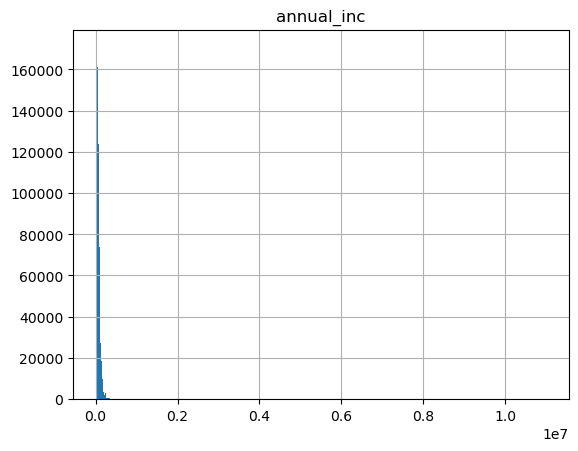

In [135]:
EDA[['annual_inc']].hist(bins=1000)

In [117]:
num_feature = ['fico_range_high',
                 'dti',
                 'inq_last_6mths',
                 'annual_inc',
                 'loan_amnt',
                 'revol_util',
                 'il_util',
                 'open_rv_24m',
                 'open_il_24m',
                 'open_rv_12m',
                 'open_il_12m',
                 'num_actv_rev_tl']

In [ ]:
num_feature

In [95]:
preprocessing = Pipeline(steps=[
    ('impute', make_pipeline(mths, util)),
    ('scale', ColumnTransformer(transformers=[
        ('cat', cat_pre, cat_feature),
        ('num', num_scale, num_feature)],
                                remainder='drop', n_jobs=-1, verbose_feature_names_out=False))])
preprocessing                           

Pipeline(steps=[('impute',
                 Pipeline(steps=[('pipeline',
                                  Pipeline(steps=[('m24',
                                                   m24_Imputer(nan_il='open_il_24m',
                                                               nan_rev='open_rv_24m')),
                                                  ('m12',
                                                   m24_Imputer(nan_il='open_il_12m',
                                                               nan_rev='open_rv_12m'))])),
                                 ('utilcalimputer',
                                  UtilCalImputer(nan_il='il_util',
                                                 nan_rev='revol_util'))])),
                ('scale',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('cat',
                                                  ColumnTransform...
                                                                                                                     strategy='uniform'))]),
                                                                                   ['dti']),
                                                                                  ('kbinsdiscretizer',
                                                                                   KBinsDiscretizer(encode='ordinal',
                                                                                                    random_state=42),
                                                                                   ['fico_range_high'])],
                                                                    verbose_feature_names_out=False),
                                                  ['fico_range_high', 'dti',
                                                   'inq_last_6mths',
                                                   'annual_inc', 'loan_amnt',
                                                   'revol_util', 'il_util',
                                                   'open_rv_24m', 'open_il_24m',
                                                   'open_rv_12m', 'open_il_12m',
                                                   'num_actv_rev_tl'])],
                                   verbose_feature_names_out=False))])

In [119]:
num_feature2 = ['fico_range_high',
                 'dti',
                 'inq_last_6mths',
                 'annual_inc',
                 'loan_amnt',
                 'revol_util',
                 'il_util',
                 'open_rv_24m',
                 'open_il_24m',
                 'num_actv_rev_tl']

In [174]:
preprocessing2 = Pipeline(steps=[
    ('impute', make_pipeline(mths, util)),
    ('scale', ColumnTransformer(transformers=[
        ('cat', cat_pre, cat_feature),
        ('num', num_scale2, num_feature2)],
                                remainder='drop', n_jobs=-1, verbose_feature_names_out=False))])                      

In [178]:
preprocessing3 = Pipeline(steps=[
    ('impute', make_pipeline(mths, util)),
    ('scale', ColumnTransformer(transformers=[
        ('cat', cat_pre, cat_feature),
        ('num', num_scale3, num_feature)],
                                remainder='drop', n_jobs=-1, verbose_feature_names_out=False))])    

In [192]:
preprocessing4 = Pipeline(steps=[
    ('impute', make_pipeline(mths, util)),
    ('scale', ColumnTransformer(transformers=[
        ('cat', cat_pre, cat_feature),
        ('num', num_scale4, num_feature)],
                                remainder='drop', n_jobs=-1, verbose_feature_names_out=False))])    

In [197]:
cat_feature2 =['emp_length',
 'addr_state',
 'term',
 'grade',
 'sub_grade']

In [205]:
num_feature5 = ['fico_range_high',
 'dti',
 'inq_last_6mths',
 'annual_inc',
 'loan_amnt',
 'revol_util',
 'il_util',
 'open_rv_24m',
 'open_il_24m',
 'num_actv_rev_tl']

In [208]:
preprocessing5 = Pipeline(steps=[
    ('impute', make_pipeline(mths, util)),
    ('scale', ColumnTransformer(transformers=[
        ('cat', cat_pre2, cat_feature2),
        ('num', num_scale5, num_feature5)],
                                remainder='drop', n_jobs=-1, verbose_feature_names_out=False))])    

## 모델

In [99]:
X_train.shape

(1089701, 150)

In [100]:
y_train.shape

(1089701,)

In [102]:
from sklearn.preprocessing import LabelEncoder

label = LabelEncoder()
label.fit(y_train)
label.classes_ = np.array(["Fully Paid", "Charged Off"], dtype=np.object_)
y_train_label = label.transform(y_train)

In [111]:
import xgboost
import lightgbm
import catboost
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.metrics import average_precision_score, matthews_corrcoef, fbeta_score, make_scorer

def impute_score(imputer, X_missing, y_missing):
    score_xgb = cross_validate(Pipeline([("imputer", imputer), 
                                         ("classifier", classifier_xgb)]), 
                               X_missing, y_missing, scoring={"MCC" : make_scorer(matthews_corrcoef), 
                                                              "PRC-AUC (AP)": "average_precision", 
                                                              "ROC-AUC": "roc_auc", 
                                                              "F-2 Score": make_scorer(fbeta_score, beta=2), 
                                                              "F-1.5 Score": make_scorer(fbeta_score, beta=1.5), 
                                                              "F-1 Score": "f1"}, cv=3, n_jobs=-1, verbose=1000, return_train_score=True)
    score_lgbm = cross_validate(Pipeline([("imputer", imputer), 
                                          ("classifier", classifier_lgbm)]), 
                                X_missing, y_missing, scoring={"MCC" : make_scorer(matthews_corrcoef), 
                                                               "PRC-AUC (AP)": "average_precision", 
                                                               "ROC-AUC": "roc_auc", 
                                                               "F-2 Score": make_scorer(fbeta_score, beta=2), 
                                                               "F-1.5 Score": make_scorer(fbeta_score, beta=1.5), 
                                                               "F-1 Score": "f1"}, cv=3, n_jobs=-1, verbose=1000, return_train_score=True)
    score_cat = cross_validate(Pipeline([("imputer", imputer), 
                                         ("classifier", classifier_cat)]), 
                               X_missing, y_missing, scoring={"MCC" : make_scorer(matthews_corrcoef), 
                                                              "PRC-AUC (AP)": "average_precision", 
                                                              "ROC-AUC": "roc_auc", 
                                                              "F-2 Score": make_scorer(fbeta_score, beta=2), 
                                                              "F-1.5 Score": make_scorer(fbeta_score, beta=1.5), 
                                                              "F-1 Score": "f1"}, cv=3, n_jobs=-1, verbose=1000, return_train_score=True)

    df_xgb = pd.DataFrame.from_dict({"train": [value.mean().round(4) for key, value in score_xgb.items() if "train" in key] + [score_xgb.get("fit_time").mean().round()], 
                                     "test": [value.mean().round(4) for key, value in score_xgb.items() if "test" in key] + [score_xgb.get("score_time").mean().round()]}).set_axis(["MCC", "PRC-AUC (AP)", "ROC-AUC", "F-2 Score", "F-1.5 Score", "F-1 Score", "fit_time, score_time"], axis=0)
    df_lgbm = pd.DataFrame.from_dict({"train": [value.mean().round(4) for key, value in score_lgbm.items() if "train" in key] + [score_lgbm.get("fit_time").mean().round()], 
                                      "test": [value.mean().round(4) for key, value in score_lgbm.items() if "test" in key] + [score_lgbm.get("score_time").mean().round()]}).set_axis(["MCC", "PRC-AUC (AP)", "ROC-AUC", "F-2 Score", "F-1.5 Score", "F-1 Score", "fit_time, score_time"], axis=0)
    df_cat = pd.DataFrame.from_dict({"train": [value.mean().round(4) for key, value in score_cat.items() if "train" in key] + [score_cat.get("fit_time").mean().round()], 
                                     "test": [value.mean().round(4) for key, value in score_cat.items() if "test" in key] + [score_cat.get("score_time").mean().round()]}).set_axis(["MCC", "PRC-AUC (AP)", "ROC-AUC", "F-2 Score", "F-1.5 Score", "F-1 Score", "fit_time, score_time"], axis=0)
    
    df_xgb.columns = [["XGBClassifier", "XGBClassifier"], ["train", "test"]]
    df_lgbm.columns = [["LGBMClassifier", "LGBMClassifier"], ["train", "test"]]
    df_cat.columns = [["CatBoostClassifier", "CatBoostClassifier"], ["train", "test"]]
    return pd.concat((df_xgb, df_lgbm, df_cat), axis=1)
    
classifier_xgb = xgboost.XGBClassifier(verbosity=3, tree_method="hist", n_jobs=-1, random_state=6, eval_metric=average_precision_score)
classifier_lgbm = lightgbm.LGBMClassifier(random_state=6, n_jobs=-1, verbosity=2, metric="average_precision")
classifier_cat = catboost.CatBoostClassifier(verbose=3, eval_metric="PRAUC", random_state=6)



In [112]:
impute_score(preprocessing, X_train, y_train_label)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   53.3s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   58.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   39.1s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   44.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  4.5min finished


XGBClassifier         LGBMClassifier          \
                             train    test          train    test   
MCC                         0.1874  0.1485         0.1461  0.1387   
PRC-AUC (AP)                0.4249  0.3806         0.3928  0.3831   
ROC-AUC                     0.7413  0.7180         0.7246  0.7186   
F-2 Score                   0.1140  0.0975         0.0826  0.0800   
F-1.5 Score                 0.1281  0.1096         0.0933  0.0904   
F-1 Score                   0.1643  0.1407         0.1216  0.1178   
fit_time, score_time       23.0000  7.0000        12.0000  8.0000   

                     CatBoostClassifier          
                                  train    test  
MCC                              0.2163  0.1523  
PRC-AUC (AP)                     0.4493  0.3823  
ROC-AUC                          0.7477  0.7196  
F-2 Score                        0.1303  0.1017  
F-1.5 Score                      0.1462  0.1141  
F-1 Score                        0.1868  0.1461  
fit_time, score_time           238.0000  6.0000

In [121]:
impute_score(preprocessing2, X_train, y_train_label)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   44.6s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   49.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   35.6s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   42.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  4.6min finished


XGBClassifier         LGBMClassifier          \
                             train    test          train    test   
MCC                         0.1814  0.1462         0.1413  0.1344   
PRC-AUC (AP)                0.4207  0.3789         0.3895  0.3804   
ROC-AUC                     0.7399  0.7164         0.7228  0.7169   
F-2 Score                   0.1089  0.0941         0.0779  0.0754   
F-1.5 Score                 0.1224  0.1058         0.0882  0.0853   
F-1 Score                   0.1575  0.1362         0.1153  0.1116   
fit_time, score_time       19.0000  6.0000        11.0000  7.0000   

                     CatBoostClassifier          
                                  train    test  
MCC                              0.2097  0.1470  
PRC-AUC (AP)                     0.4443  0.3796  
ROC-AUC                          0.7461  0.7177  
F-2 Score                        0.1247  0.0961  
F-1.5 Score                      0.1401  0.1080  
F-1 Score                        0.1795  0.1388  
fit_time, score_time           246.0000  5.0000

In [179]:
impute_score(preprocessing3, X_train, y_train_label)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   46.3s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   51.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   38.5s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   49.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  4.9min finished


XGBClassifier         LGBMClassifier          \
                             train    test          train    test   
MCC                         0.1843  0.1489         0.1423  0.1355   
PRC-AUC (AP)                0.4221  0.3804         0.3908  0.3816   
ROC-AUC                     0.7389  0.7170         0.7232  0.7176   
F-2 Score                   0.1111  0.0961         0.0787  0.0764   
F-1.5 Score                 0.1250  0.1081         0.0891  0.0864   
F-1 Score                   0.1606  0.1390         0.1164  0.1129   
fit_time, score_time       21.0000  6.0000        17.0000  6.0000   

                     CatBoostClassifier          
                                  train    test  
MCC                              0.2131  0.1496  
PRC-AUC (AP)                     0.4466  0.3806  
ROC-AUC                          0.7456  0.7181  
F-2 Score                        0.1264  0.0982  
F-1.5 Score                      0.1420  0.1104  
F-1 Score                        0.1819  0.1416  
fit_time, score_time           256.0000  6.0000

In [193]:
impute_score(preprocessing4, X_train, y_train_label)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   50.2s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   56.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   47.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  4.9min finished


XGBClassifier         LGBMClassifier          \
                             train    test          train    test   
MCC                         0.1838  0.1462         0.1427  0.1351   
PRC-AUC (AP)                0.4205  0.3783         0.3899  0.3811   
ROC-AUC                     0.7370  0.7160         0.7222  0.7169   
F-2 Score                   0.1101  0.0944         0.0793  0.0765   
F-1.5 Score                 0.1238  0.1062         0.0897  0.0865   
F-1 Score                   0.1593  0.1366         0.1172  0.1130   
fit_time, score_time       23.0000  7.0000        14.0000  7.0000   

                     CatBoostClassifier          
                                  train    test  
MCC                              0.2105  0.1487  
PRC-AUC (AP)                     0.4438  0.3792  
ROC-AUC                          0.7433  0.7170  
F-2 Score                        0.1245  0.0973  
F-1.5 Score                      0.1398  0.1093  
F-1 Score                        0.1793  0.1404  
fit_time, score_time           256.0000  6.0000

In [209]:
impute_score(preprocessing5, X_train, y_train_label)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   42.4s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   47.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   38.6s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   43.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  4.5min finished


XGBClassifier         LGBMClassifier          \
                             train    test          train    test   
MCC                         0.1776  0.1407         0.1379  0.1303   
PRC-AUC (AP)                0.4148  0.3739         0.3857  0.3774   
ROC-AUC                     0.7332  0.7132         0.7195  0.7144   
F-2 Score                   0.1044  0.0890         0.0753  0.0723   
F-1.5 Score                 0.1175  0.1003         0.0853  0.0819   
F-1 Score                   0.1516  0.1295         0.1117  0.1073   
fit_time, score_time       16.0000  6.0000        13.0000  7.0000   

                     CatBoostClassifier          
                                  train    test  
MCC                              0.2015  0.1414  
PRC-AUC (AP)                     0.4350  0.3742  
ROC-AUC                          0.7384  0.7139  
F-2 Score                        0.1160  0.0907  
F-1.5 Score                      0.1305  0.1021  
F-1 Score                        0.1681  0.1316  
fit_time, score_time           242.0000  5.0000